# Условие задачи

 Необходимо провести тщательный анализ данных и сформулировать обоснованные выводы относительно того, в какие виды климатического оборудования следует инвестировать в первую очередь, чтобы повысить уровень удовлетворённости клиентов . Кроме того, важно определить, какие аспекты следует принимать во внимание при развитии бизнеса.

**Кратко про пункты**







Предобработка данных:

1.   Изучение и заполнение пропусков
2.   Выявление выбросов и изучение данных, которые не попали в 1-ый пункт

Проведение рассчетов и анализов:


1.   Добавление новых фичей, составление матрицы корреляций
2.   Составление гипотез и их проверка
3.   Регрессионная модель для предсказания температуры

# 1. Загрузка датасета

In [3]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

warnings.filterwarnings("ignore")

In [4]:
import pandas as pd

df = pd.read_csv("data.csv", sep=";", encoding="utf-8")
df.head()

,Год,Время года,Климат,Город,Страна,Способ охлаждения,Режим при смешанном типе охлаждения,Способ обогрева,Возраст,Пол,...,Скорость воздуха,Рост,Вес,Занавески,Вентилятор,Окно,Двери,Отопление,Среднемесячная температура на улице,Количество рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0


<Axes: >

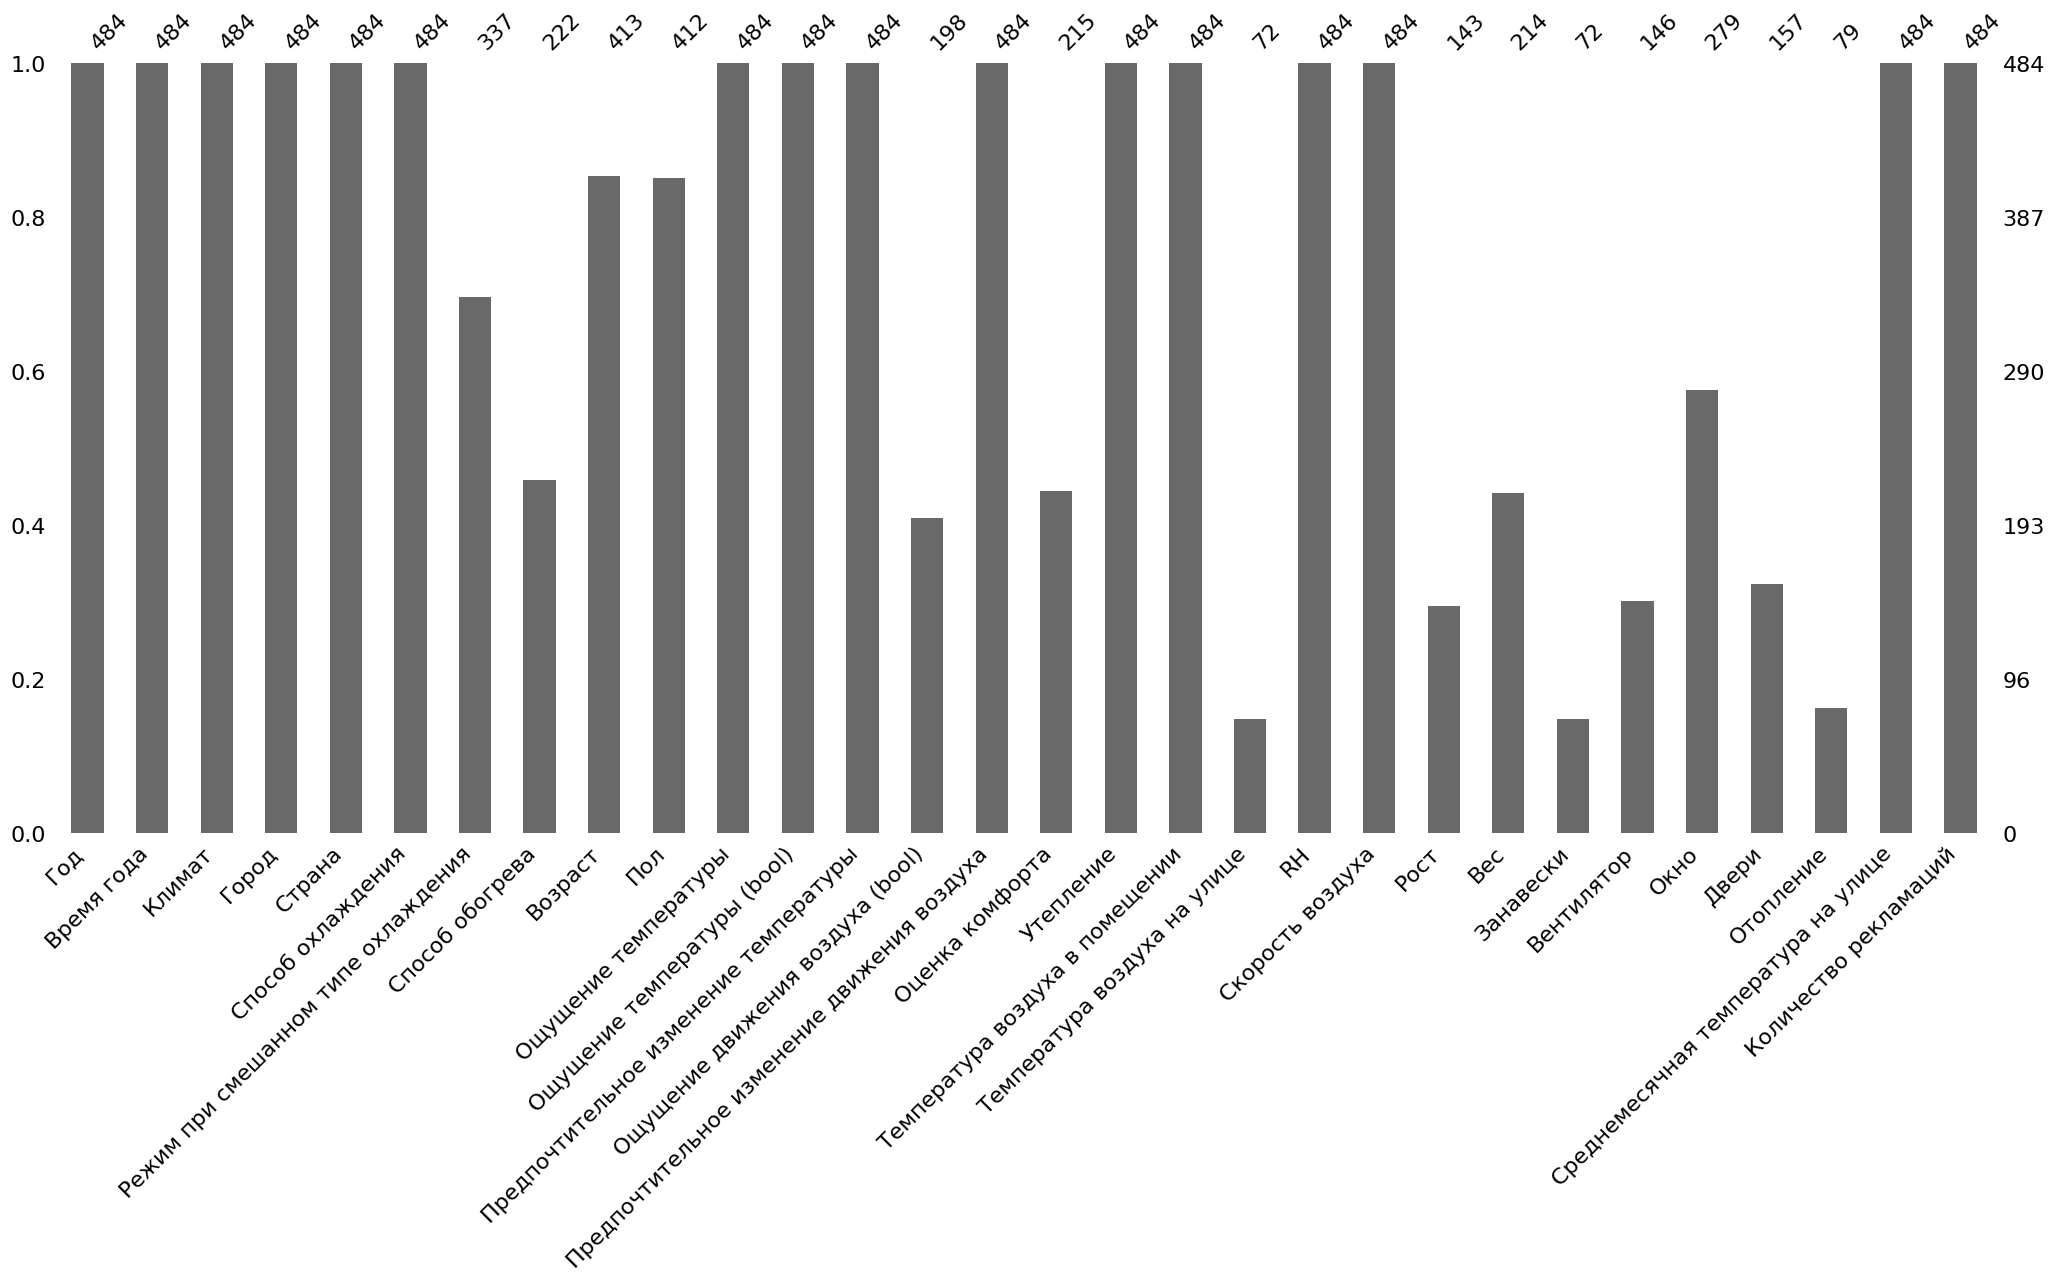

In [5]:
# Смотрим на пропуски в данных
msno.bar(df)
# Пропусков довольно много, есть столбцы, где их больше половины

# 2. Изучение и заполнение пропусков в данных, разведочный анализ

## Перевод колонок в PEP8

In [6]:
# pep8
df.columns = df.columns.str.lower().str.replace(" ", "_")

## Проверка на дубликаты

In [7]:
# Проверка на дубликаты
df[df.duplicated(keep=False)]

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
481,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,...,0.02,NaN,76.0,NaN,NaN,0.0,0.0,NaN,21.6,0
482,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,...,0.02,NaN,76.0,NaN,NaN,0.0,0.0,NaN,21.6,0
483,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,...,0.02,NaN,76.0,NaN,NaN,0.0,0.0,NaN,21.6,0


In [8]:
df = df.drop_duplicates(keep="first")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 481
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          482 non-null    float64
 1   время_года                                   482 non-null    object 
 2   климат                                       482 non-null    object 
 3   город                                        482 non-null    object 
 4   страна                                       482 non-null    object 
 5   способ_охлаждения                            482 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          335 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          410 non-null    object 
 10  ощущени

Были удалены дубликаты

## Исправление опечаток в данных

In [10]:
# исправление ошибок в данных
df["год"] = df["год"].astype(int)
df.loc[df["климат"] == "Cубтроп океанич", "климат"] = (
    "Cубтропический океанический"
)
df.loc[
    df["предпочтительное_изменение_температуры"] == "Холодн",
    "предпочтительное_изменение_температуры",
] = "Холоднее"
df.loc[
    df["предпочтительное_изменение_температуры"] == "Тепле",
    "предпочтительное_изменение_температуры",
] = "Теплее"


Были исправлены опечатки в данных

## Заполнение пропусков

In [11]:
df["режим_при_смешанном_типе_охлаждения"].value_counts()

,count
режим_при_смешанном_типе_охлаждения,
Кондиционирование,235
Вентиляция,100


In [12]:
# По условию задачи, nan значения у зданий, не относящиеся к смешанному типу
df["режим_при_смешанном_типе_охлаждения"] = df[
    "режим_при_смешанном_типе_охлаждения"
].fillna("Не смешанный")

In [13]:
df["пол"].value_counts()

,count
пол,
Мужской,254
Женский,156


In [14]:
# пропущено незначительное кол-во значений и есть небольшой перевес в сторону одного класса, поэтому лучше заполнить модой, что не повлияет на распределение классов
df["пол"] = df["пол"].fillna(df["пол"].mode().values[0])

In [15]:
df["ощущение_движения_воздуха_(bool)"].value_counts()

,count
ощущение_движения_воздуха_(bool),
1.0,149
0.0,49


<Axes: ylabel='ощущение_температуры'>

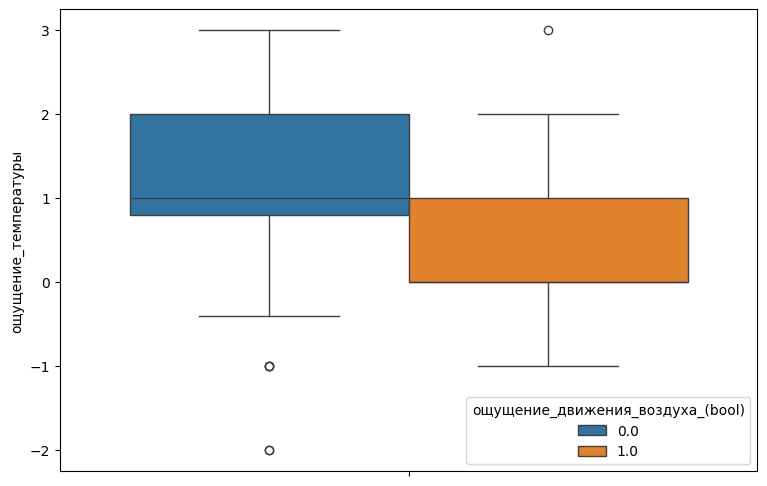

In [16]:
# здесь ситуация выглядит по-другому, для большинства ощущение движения воздуха оказалось приемлемым
# т.к. у не nan значений оценки комфорта нет данных по ощущение_движения_воздуха_(bool), будем строить распределение по ощущению температуры
data = df[(df["ощущение_температуры"].isna() == False) & (df["ощущение_движения_воздуха_(bool)"].isna() == False)][["ощущение_движения_воздуха_(bool)", "ощущение_температуры"]]
plt.figure(figsize=(9, 6))
sns.boxplot(data, y="ощущение_температуры", hue="ощущение_движения_воздуха_(bool)")
# Заметно, что у людей с ощущение_движения_воздуха равным неприемлемо(0), ощущение темературы выше, им жарче, нежели людям с приемлемым ощущением движения воздуха(у них ощущение температуры комфортное)

<Axes: ylabel='ощущение_температуры'>

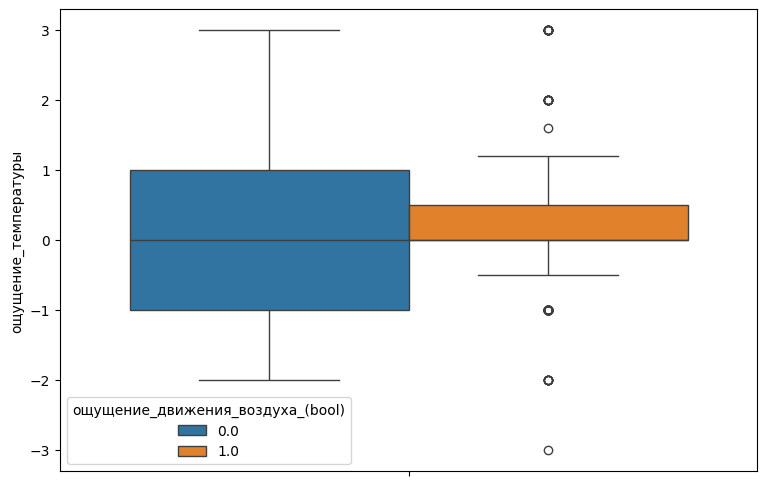

In [17]:
# Заполним пропуски интерполяцией и посмортим на это распределение еще раз
df["ощущение_движения_воздуха_(bool)"] = df[
    "ощущение_движения_воздуха_(bool)"
].interpolate(method="ffill")
df["ощущение_движения_воздуха_(bool)"] = df[
    "ощущение_движения_воздуха_(bool)"
].interpolate(method="bfill")

plt.figure(figsize=(9, 6))
sns.boxplot(df, y="ощущение_температуры", hue="ощущение_движения_воздуха_(bool)")
# Ощущение температуры у людей с неприемлемым движением воздуха стало ниже(комфортнее), но не сильно, остались те, которым все еще жарко
# А вот у людей, у которых приемлемое ощущение движения воздуха, сохранилось изначальное распределение, при этом добавилось несколько выбросов, что не критично сказывавется на общем распределении
# Интерполяция показала себя хорошо

In [18]:
df["занавески"].value_counts()
# пропущено большое кол-во значений, и если не считать nan, то классы распределены одинаково и заполнить пропуски в перевес какого-то класса нецелесообразно,
# давайте посмотрим с чем она коррелирует

,count
занавески,
1.0,37
0.0,35


In [19]:
df.corr(numeric_only=True)

,год,возраст,ощущение_температуры,ощущение_температуры_(bool),ощущение_движения_воздуха_(bool),оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
год,1.000000,-0.277055,-0.156494,0.005304,0.272571,0.325765,0.612443,0.114632,NaN,-0.362152,0.001548,NaN,NaN,NaN,0.026689,-0.187883,0.236015,NaN,0.071991,0.053720
возраст,-0.277055,1.000000,0.058165,-0.041983,0.016830,0.077740,-0.072402,-0.024297,0.106440,0.131372,-0.038591,-0.097116,0.075877,-0.171337,0.018135,0.109940,-0.073583,-0.372728,-0.060301,-0.160630
ощущение_температуры,-0.156494,0.058165,1.000000,-0.398083,-0.029383,-0.317231,-0.142867,-0.000692,0.275372,0.063048,-0.069468,0.033714,-0.005040,0.072025,0.219644,0.091843,0.046713,-0.160918,-0.025617,0.059486
ощущение_температуры_(bool),0.005304,-0.041983,-0.398083,1.000000,0.285756,0.496288,0.036565,-0.056147,-0.081479,0.060524,0.013395,0.010663,-0.031445,-0.048131,-0.113796,-0.017374,-0.000527,-0.032661,-0.063473,-0.175284
ощущение_движения_воздуха_(bool),0.272571,0.016830,-0.029383,0.285756,1.000000,0.325765,0.217289,-0.187794,NaN,0.244269,-0.222432,NaN,NaN,NaN,0.026689,-0.077789,-0.043377,NaN,-0.259599,-0.186718
оценка_комфорта,0.325765,0.077740,-0.317231,0.496288,0.325765,1.000000,0.158423,-0.145866,-0.036382,0.182423,-0.055533,0.052382,-0.001451,-0.305342,-0.250993,-0.036861,NaN,0.307725,-0.167358,-0.501273
утепление,0.612443,-0.072402,-0.142867,0.036565,0.217289,0.158423,1.000000,-0.089705,0.061003,-0.368083,-0.011990,-0.162153,0.030387,0.103045,-0.290608,-0.230785,0.129226,0.201979,-0.120152,0.077297
температура_воздуха_в_помещении,0.114632,-0.024297,-0.000692,-0.056147,-0.187794,-0.145866,-0.089705,1.000000,-0.015276,-0.176953,-0.023156,0.102444,-0.111753,-0.114606,0.033303,0.147598,0.388065,-0.447929,0.143099,0.027919
температура_воздуха_на_улице,NaN,0.106440,0.275372,-0.081479,NaN,-0.036382,0.061003,-0.015276,1.000000,-0.309455,0.026373,NaN,NaN,-0.372815,-0.372815,NaN,NaN,NaN,0.032251,0.185739
rh,-0.362152,0.131372,0.063048,0.060524,0.244269,0.182423,-0.368083,-0.176953,-0.309455,1.000000,-0.138319,-0.082149,0.016986,0.362570,0.266836,0.190577,-0.249360,-0.119885,-0.127464,-0.140071


In [20]:
# есть значительная обратная зависимость с оценкой комфорта и температурой воздуха на улице, а также прямая зависимость с относительная влажностью и режимом вентилятора
# и если зависимость занавесок между оценкой комфорта, относительная влажностью и режимом вентилятора можно объяснить логичеcки, то влиянее занавесок на
# температуру воздуха на улице сложно объяснить. Т.к. данных по этой переменной очень мало, и заполнять ее сложно, т.к. можно заполнить равномерно или в перевес какаго-то класса, но
# при этом истинные зависимости могут исчезнуть и мы сделаем ложные выводы, то было принято решение удалить данный столбец

df = df.drop(columns="занавески", axis=1)

In [21]:
df["вентилятор"].value_counts()

,count
вентилятор,
1.0,77
0.0,69


In [22]:
# можно было сказать, что распределение классов нормально, но есть небольшой перевес в сторону 1, что следует отразить в заполнении
mask = df['вентилятор'].isna()
ind = df['вентилятор'].loc[mask].sample(frac=0.6).index

df.loc[ind, 'вентилятор'] = 1
df['вентилятор'] = df['вентилятор'].fillna(0)

In [23]:
df["окно"].value_counts()

,count
окно,
0.0,208
1.0,69


In [24]:
# Явный перевес в сторону класса 0
df["окно"] = df["окно"].interpolate(method="ffill")
df["окно"] = df["окно"].interpolate(method="bfill")

In [25]:
df["двери"].value_counts()

,count
двери,
0.0,126
1.0,29


In [26]:
# Такая же ситуация и с дверьми
df["двери"] = df["двери"].interpolate(method="ffill")
df["двери"] = df["двери"].interpolate(method="bfill")

In [27]:
df["отопление"].value_counts()
# Тоже мало данных, отопление коррелирует с многими переменными, поэтому удаление этой переменной нецелесообразно
# давайте посмотрим на отопление летом

,count
отопление,
1.0,62
0.0,17


In [28]:
df[df["время_года"] == "Лето"]["отопление"].value_counts()
# Странно, что летом кто-то включает отопление, посмотрим какие странны у нас есть

,count
отопление,
1.0,43
0.0,11


In [29]:
df["страна"].unique()

array(['США', 'Австралия', 'Индия'], dtype=object)

In [30]:
df["страна"].value_counts()
# В этих странах лето теплое(информация из интернета), теперь взгялнем на климаты

,count
страна,
Индия,212
Австралия,198
США,72


In [31]:
df["климат"].unique()
# По инфоррмации из интернета в данных климатах лето теплое-жаркое, поэтому отопление летом не нужно, заполним пропуски с отоплением 0, где время года - лето/весна
# а где время года - зима/осень, заполнить 1

array(['Cубтропический океанический', 'Субтропическое высокогорье',
       'Жаркий полузасушливый', 'Тропическая влажная саванна',
       'Влажный субтропический муссонный'], dtype=object)

In [32]:
summer = df[(df["время_года"] == "Лето")]["отопление"]
summer = summer.fillna(0.0)

spring = df[(df["время_года"] == "Весна")]["отопление"]
spring = spring.fillna(0.0)

In [33]:
winter = df[(df["время_года"] == "Зима")]["отопление"]
winter = winter.fillna(1.0)

autumn = df[(df["время_года"] == "Осень")]["отопление"]
autumn = autumn.fillna(1.0)

In [34]:
df["отопление"] = df["отопление"].fillna(pd.Series(summer, index=df[(df["время_года"] == "Лето") & (df['отопление'].isna())].index))
df["отопление"] = df["отопление"].fillna(pd.Series(winter, index=df[(df["время_года"] == "Зима") & (df['отопление'].isna())].index))

df["отопление"] = df["отопление"].fillna(pd.Series(spring, index=df[(df["время_года"] == "Весна") & (df['отопление'].isna())].index))
df["отопление"] = df["отопление"].fillna(pd.Series(autumn, index=df[(df["время_года"] == "Осень") & (df['отопление'].isna())].index))

In [35]:
df["отопление"].value_counts()

,count
отопление,
0.0,353
1.0,129


In [36]:
# приведение float к int
df["ощущение_движения_воздуха_(bool)"] = df[
    "ощущение_движения_воздуха_(bool)"
].astype(int)
df["ощущение_температуры_(bool)"] = df["ощущение_температуры_(bool)"].astype(
    int
)
df["отопление"] = df["отопление"].astype(int)
df["двери"] = df["двери"].astype(int)
df["окно"] = df["окно"].astype(int)
df["вентилятор"] = df["вентилятор"].astype(int)


In [37]:
df["способ_обогрева"].value_counts()

,count
способ_обогрева,
Механическое отопление,222


In [38]:
# Добавим для значений nan класс другое, т.к. не можем точно назвать способ обогрева
df["способ_обогрева"] = df["способ_обогрева"].fillna("Другое")

<Axes: xlabel='возраст', ylabel='Count'>

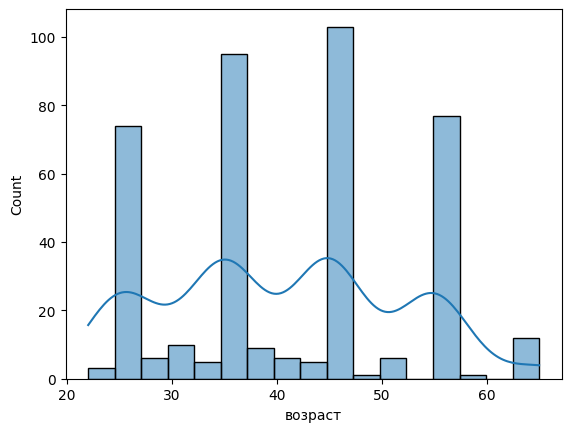

In [39]:
sns.histplot(df, x="возраст", kde=True)
# из графика можно заметить что больниство клиентов кампании приходится на возраст 25, 35, 45 и 55 лет

In [40]:
df[df["возраст"].isna() == True].shape[0]

69

In [41]:
df["возраст"].value_counts()

,count
возраст,
45.0,99
35.0,91
55.0,77
25.0,67
65.0,12
43.0,5
38.0,5
34.0,5
46.0,4


In [42]:
df["возраст"].median(), df["возраст"].mean(), df["возраст"].mode()

(42.0,
 40.634382566585955,
 0    45.0
 Name: возраст, dtype: float64)

In [43]:
# медиана ближе к наиболее часто встречаемому значению, поэтому заполним пропуски ей
df["возраст"] = df["возраст"].fillna(df["возраст"].median())

<Axes: xlabel='оценка_комфорта', ylabel='Count'>

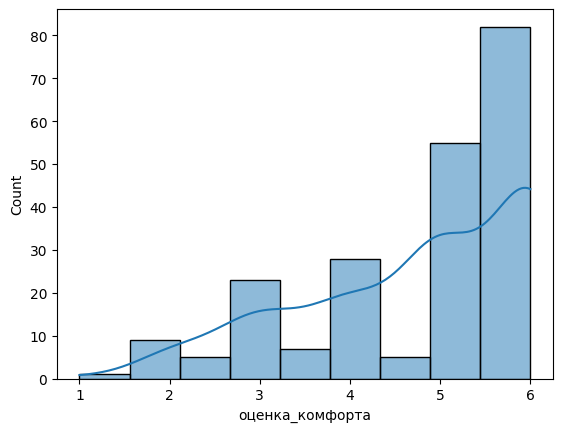

In [44]:
sns.histplot(df, x="оценка_комфорта", kde=True)

In [45]:
df["оценка_комфорта"].median(), df["оценка_комфорта"].mean(), df["оценка_комфорта"].mode()

(5.0,
 4.772093023255814,
 0    6.0
 Name: оценка_комфорта, dtype: float64)

In [46]:
df["оценка_комфорта"].value_counts()

,count
оценка_комфорта,
6.0,82
5.0,54
4.0,27
3.0,21
2.0,9
3.5,7
4.5,5
2.5,3
4.3,1


In [47]:
# Сначала мы хотели заполнить пропуски медианой, но посмотрев на гистограмму, увидели "прямую" линию и решили что интерполяция подойдет лучше
df["оценка_комфорта"] = df["оценка_комфорта"].interpolate(method="linear")

<Axes: xlabel='рост', ylabel='Count'>

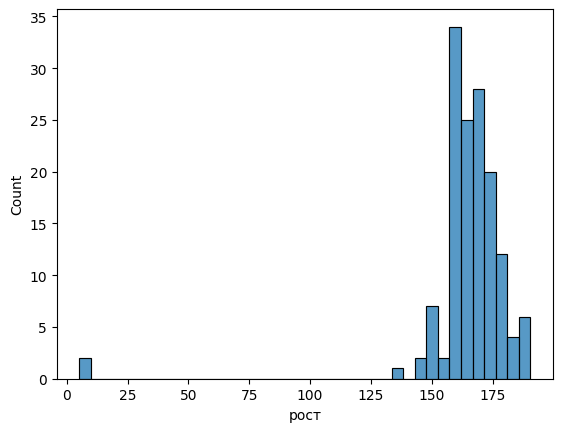

In [48]:
sns.histplot(df, x="рост")

In [49]:
df["рост"].median(), df["рост"].mean(), df["рост"].mode()

(165.1,
 164.41167832167835,
 0    160.0
 Name: рост, dtype: float64)

In [50]:
# видно выбросы из гистограммы(человек с ростом 10 - это аномальное значение), мы решили целесообразнее будет сделать замену вместо удаления данного элемента, т.к. данных очень мало
Q1 = df["рост"].quantile(0.25)
Q3 = df["рост"].quantile(0.75)
IQR = Q3 - Q1

replace_value = df["рост"].mode().values[0]

In [51]:
df["рост"] = df["рост"].apply(
    lambda x: replace_value if x < Q1 - 3 * IQR else x
)


<Axes: xlabel='рост', ylabel='Count'>

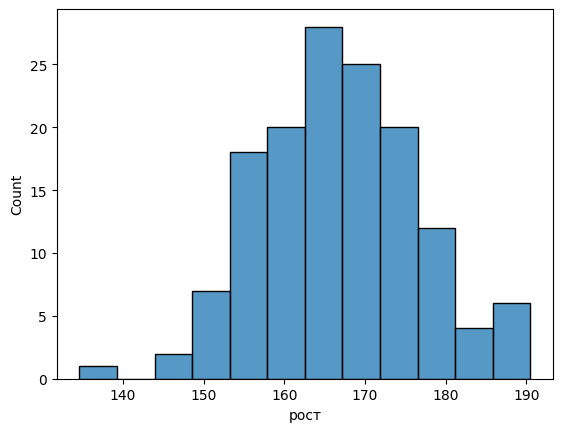

In [52]:
sns.histplot(df, x="рост")

In [53]:
df["рост"].median(), df["рост"].mean(), df["рост"].mode()

(165.1,
 166.5727272727273,
 0    160.0
 Name: рост, dtype: float64)

In [54]:
# выбрали начальное значения для заполнения интерполяцией моду, т.к. она делает полученные результаты "более нормально распределенными", нежели медиана или среднее
df["рост"][0] = df["рост"].mode().values[0]
df["рост"] = df["рост"].interpolate(method="linear")

<Axes: xlabel='рост', ylabel='Count'>

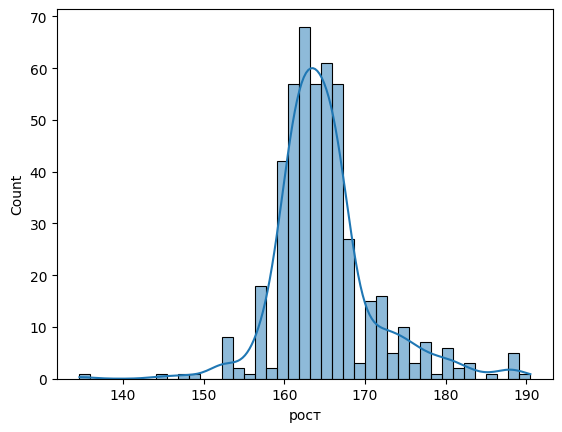

In [55]:
sns.histplot(df, x="рост", kde=True)

<Axes: xlabel='рост'>

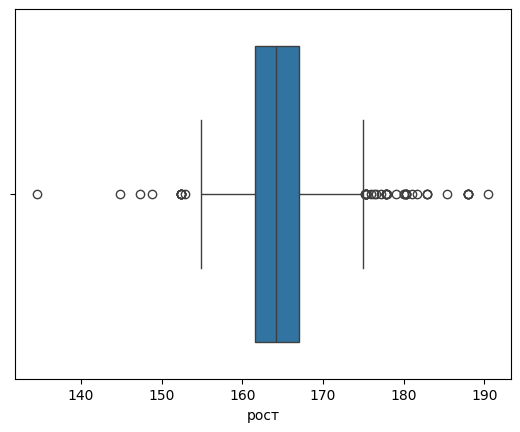

In [56]:
sns.boxplot(df, x="рост")

In [57]:
# После заполнения пропусков появились выбросы, но это не значит что их нужно удалять, люди с ростом > 180 могут быть, это не аномальные значения,
# было принято решение заменить только рост людей <= 140
df["рост"] = df["рост"].apply(lambda x: replace_value if x <= 140 else x)

<Axes: xlabel='вес', ylabel='Count'>

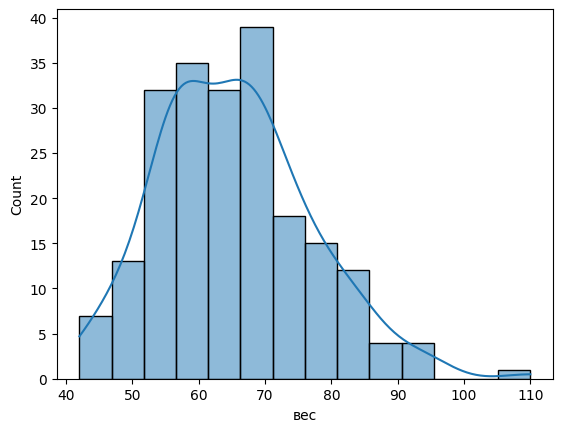

In [58]:
sns.histplot(df, x="вес", kde=True)

In [59]:
df["вес"].median(), df["вес"].mean(), df["вес"].mode()

(65.0,
 65.37264150943396,
 0    65.0
 Name: вес, dtype: float64)

In [60]:
# для завполнения пропусков в колонке вес, воспользуемся формулой Брока для идеального веса
df["вес"] = df[df["пол"] == "Мужской"]["вес"].fillna((df["рост"] - 100) * 1.15)
df["вес"] = df["вес"].fillna((df["рост"] - 110) * 1.15)

<Axes: xlabel='вес', ylabel='Count'>

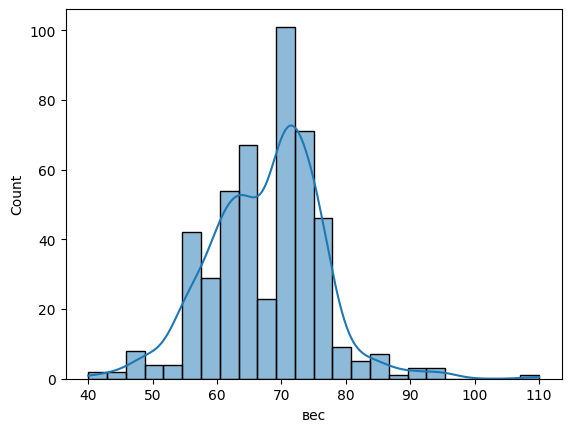

In [61]:
sns.histplot(df, x="вес", kde=True)

В итоге всех преобразований, были заполнены необходимые пропуски

## Исправления в данных с температурой в США

В ходе анализа данных были выявлены аномалии, наблюдаемые в США. Можно предположить, что эти выбросы связаны с особенностями измерительной системы температуры в регионе, выраженной в градусах Фаренгейта.

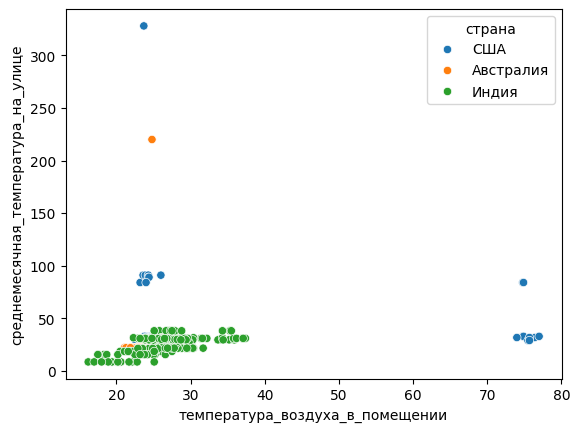

In [62]:
sns.scatterplot(data=df, x='температура_воздуха_в_помещении',
                y='среднемесячная_температура_на_улице',
                hue='страна')
plt.show()

In [63]:
# Обработка температуры воздуха в помещении
column_indoor = "температура_воздуха_в_помещении"
indices_indoor = df[df[column_indoor] > 60].index
df.loc[indices_indoor, column_indoor] = (
    (df.loc[indices_indoor, column_indoor] - 32) * 5 / 9
).round(1)
# Обработка среднемесячной температуры на улице
column_outdoor = "среднемесячная_температура_на_улице"
indices_outdoor_range = df[
    (df[column_outdoor] > 50) & (df[column_outdoor] < 100)
].index
df.loc[indices_outdoor_range, column_outdoor] = (
    (df.loc[indices_outdoor_range, column_outdoor] - 32) * 5 / 9
).round(1)
# Преобразование температур 100 и выше, разделив на 10
indices_outdoor_high = df[df[column_outdoor] >= 100].index
df.loc[indices_outdoor_high, column_outdoor] = (
    df.loc[indices_outdoor_high, column_outdoor] / 10
).round(1)


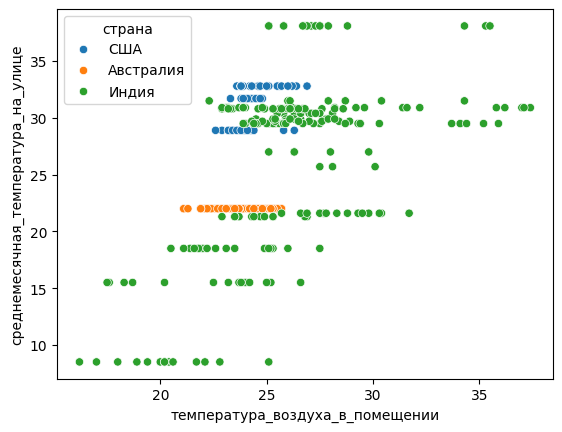

In [64]:
sns.scatterplot(data=df, x='температура_воздуха_в_помещении',
                y='среднемесячная_температура_на_улице',
                hue='страна')
plt.show()

<Axes: xlabel='температура_воздуха_в_помещении', ylabel='Count'>

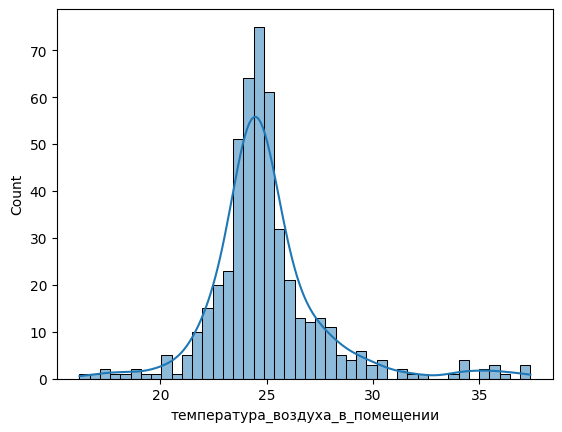

In [65]:
sns.histplot(df, x="температура_воздуха_в_помещении", kde=True)

были испарвлены данные по температуре в США

## Линейная модель для заполнения пропусков температуры


Было испробавно множество методов заполнения столбца температура_воздуха_на_улице, но т.к. пропусков в данном столбце больше 80 %, то методы не приближали распределение к нормальному, с этой задачей лучше всего справилась регрессионная модель

In [66]:
features = [
    "время_года",
    "климат",
    "город",
    "страна",
    "ощущение_температуры",
    "rh",
    "среднемесячная_температура_на_улице",
    "температура_воздуха_на_улице",
]

In [67]:
train_df = df[features].reset_index(drop=True)

Далее написан код для удаления/замены выбросов, которе мы заметили в ходе анализа фичей для модели

In [68]:
train_df["ощущение_температуры"].value_counts()

,count
ощущение_температуры,
0.0,225
1.0,79
-1.0,66
2.0,26
3.0,24
-2.0,22
-0.5,10
0.5,6
1.1,5


In [69]:
def filt(x):
    if x not in [
        -3.0,
        -1.4,
        -1.5,
        0.6,
        -1.3,
        -0.2,
        -0.1,
        0.2,
    ]:  # строки с данными значением фичи встречаются единожды, что может навредить процессу обучения модели, но они важны для бизнеса, было принято решение удалить их
        return x


train_df["ощущение_температуры"] = train_df["ощущение_температуры"].apply(filt)


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   время_года                           482 non-null    object 
 1   климат                               482 non-null    object 
 2   город                                482 non-null    object 
 3   страна                               482 non-null    object 
 4   ощущение_температуры                 474 non-null    float64
 5   rh                                   482 non-null    float64
 6   среднемесячная_температура_на_улице  482 non-null    float64
 7   температура_воздуха_на_улице         72 non-null     float64
dtypes: float64(4), object(4)
memory usage: 30.2+ KB


In [71]:
train_df = train_df.dropna().reset_index(drop=True)

In [72]:
# Обработка категориальных фичей
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

ohe = OneHotEncoder(sparse_output=False)
train = pd.DataFrame(ohe.fit_transform(train_df[["время_года", "климат", "город", "страна"]]), columns=ohe.get_feature_names_out())

In [73]:
df_ohe = pd.concat([train.reset_index(drop=True), train_df], axis=1)
df_ohe = df_ohe.drop(["время_года", "климат", "город", "страна"], axis=1)

In [74]:
# т.к. данных для обучения слишком мало, то обучать модель будем не деля данные на train и тест, а валидацию проведем на train датасете
model = LinearRegression()

model.fit(df_ohe.drop(columns="температура_воздуха_на_улице"), df_ohe['температура_воздуха_на_улице'])

LinearRegression()

In [75]:
preds = model.predict(df_ohe.drop(columns="температура_воздуха_на_улице"))

In [76]:
# достаточно низкая ошибка, есть предположения что модель переобучилась, но данных для валидации нет :)
from sklearn.metrics import mean_absolute_error, r2_score
round(mean_absolute_error(df_ohe['температура_воздуха_на_улице'], preds), 2)

0.37

In [77]:
# теперь заполним пропуски, предварительно обработав входные данные для модели
test_data = df[df["температура_воздуха_на_улице"].isna() == True][features].reset_index(drop=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   время_года                           410 non-null    object 
 1   климат                               410 non-null    object 
 2   город                                410 non-null    object 
 3   страна                               410 non-null    object 
 4   ощущение_температуры                 410 non-null    float64
 5   rh                                   410 non-null    float64
 6   среднемесячная_температура_на_улице  410 non-null    float64
 7   температура_воздуха_на_улице         0 non-null      float64
dtypes: float64(4), object(4)
memory usage: 25.8+ KB


In [78]:
test = pd.DataFrame(ohe.fit_transform(test_data[["время_года", "климат", "город", "страна"]]), columns=ohe.get_feature_names_out())

df_test = pd.concat([test.reset_index(drop=True), test_data], axis=1)
df_test = df_test.drop(["время_года", "климат", "город", "страна"], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   время_года_Весна                         410 non-null    float64
 1   время_года_Зима                          410 non-null    float64
 2   время_года_Лето                          410 non-null    float64
 3   время_года_Осень                         410 non-null    float64
 4   климат_Cубтропический океанический       410 non-null    float64
 5   климат_Влажный субтропический муссонный  410 non-null    float64
 6   климат_Жаркий полузасушливый             410 non-null    float64
 7   климат_Субтропическое высокогорье        410 non-null    float64
 8   климат_Тропическая влажная саванна       410 non-null    float64
 9   город_Ахмедабад                          410 non-null    float64
 10  город_Бангалор                           410 non-n

In [79]:
x_test = df_test.drop(columns=["температура_воздуха_на_улице", "время_года_Весна", "время_года_Зима", "время_года_Осень",
                               "климат_Влажный субтропический муссонный", "климат_Жаркий полузасушливый", "климат_Субтропическое высокогорье",
                               "климат_Тропическая влажная саванна", "город_Ахмедабад", "город_Бангалор", "город_Дели", "город_Сидней", "город_Хайдарабад", "город_Ченнай", "страна_Австралия"], axis=1)
x_test["город_Шимла"] = x_test["город_Шимла"].map(lambda x: 0)
x_test["страна_Индия"] = x_test["страна_Индия"].map(lambda x: 0)

x_test = x_test.rename(columns={"город_Шимла": "город_Техас", "страна_Индия": "страна_США"})

values = model.predict(x_test)

In [80]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   время_года_Лето                      410 non-null    float64
 1   климат_Cубтропический океанический   410 non-null    float64
 2   город_Техас                          410 non-null    int64  
 3   страна_США                           410 non-null    int64  
 4   ощущение_температуры                 410 non-null    float64
 5   rh                                   410 non-null    float64
 6   среднемесячная_температура_на_улице  410 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 22.5 KB


In [81]:
df["температура_воздуха_на_улице"] = df["температура_воздуха_на_улице"].fillna(pd.Series(values, index=df[df['температура_воздуха_на_улице'].isna()].index))

<Axes: xlabel='температура_воздуха_на_улице', ylabel='Count'>

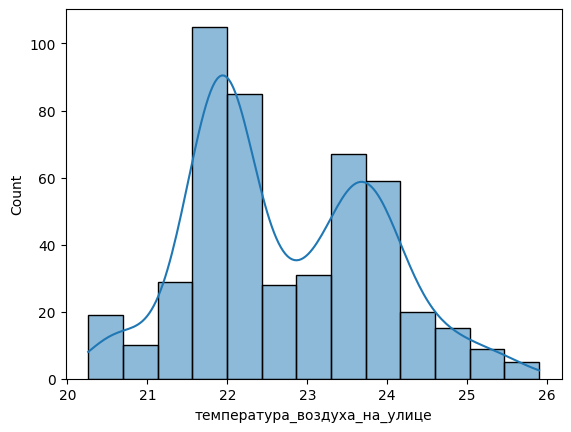

In [82]:
sns.histplot(df, x="температура_воздуха_на_улице", kde=True)
# модель хорошо справилась с распределением, скорее всего не переобучилась

<Axes: xlabel='температура_воздуха_на_улице'>

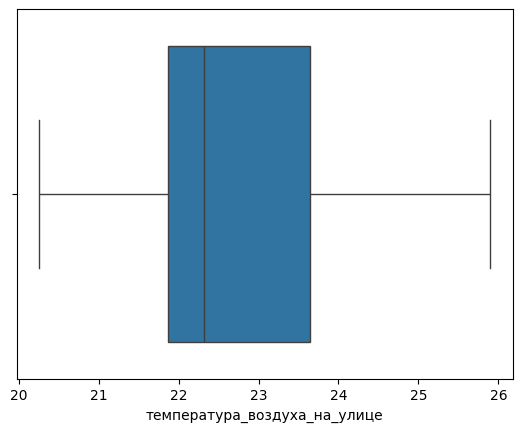

In [83]:
sns.boxplot(df, x="температура_воздуха_на_улице")

<Axes: >

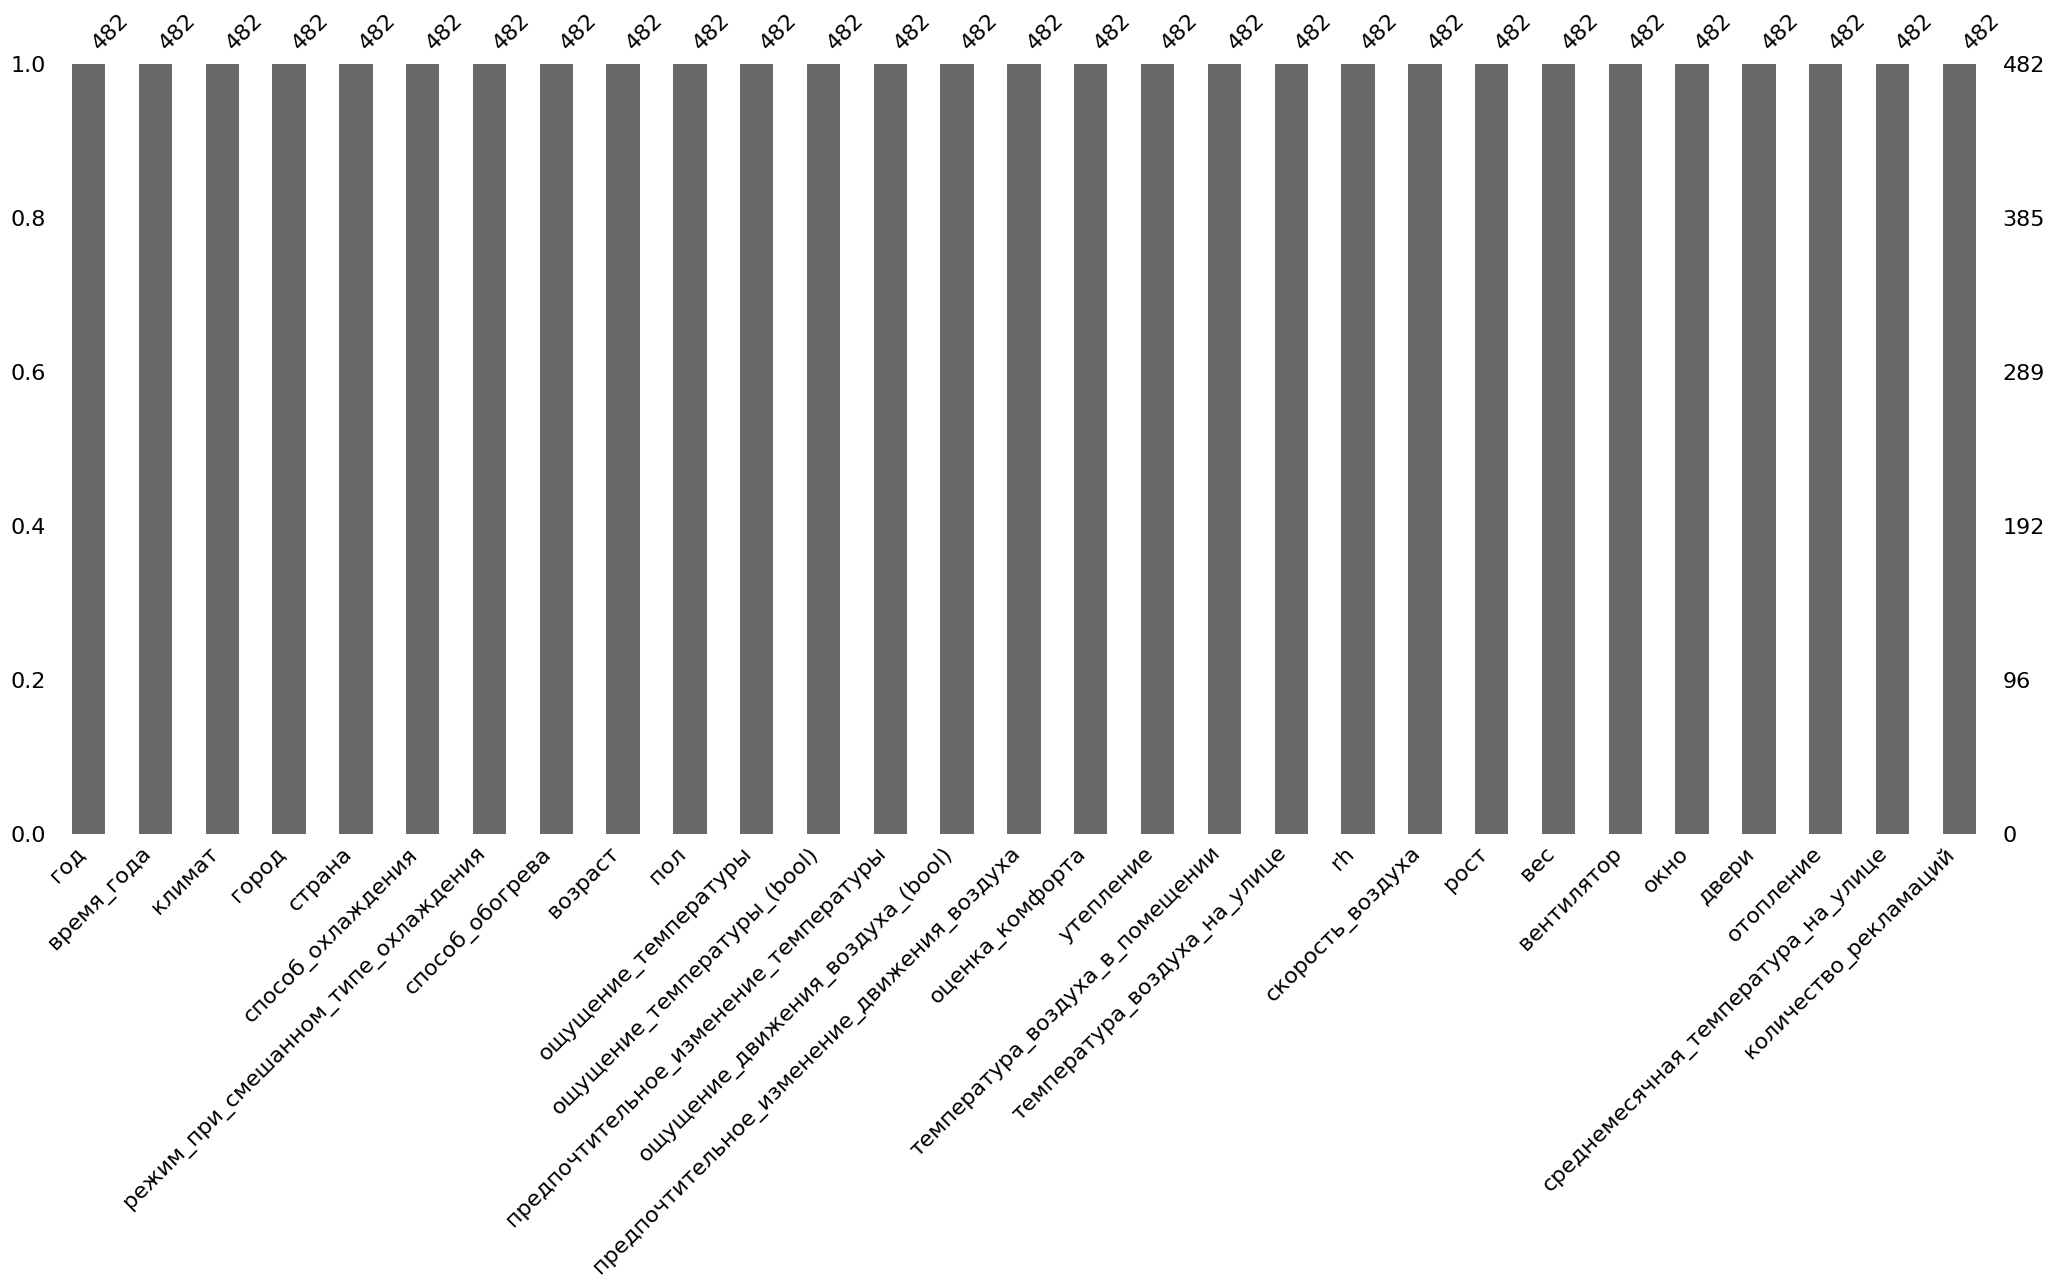

In [84]:
# Посмотрим на датасет после заполнения всех пропусков
msno.bar(df)

## Вывод предобработки
### В ходе предобработки данных были убраны опечатки, дубликаты. Также были заполнены сответствующими методами пропуски в данных.

## Исследование данных, в которых изначально не было пропусков

<Axes: xlabel='год', ylabel='count'>

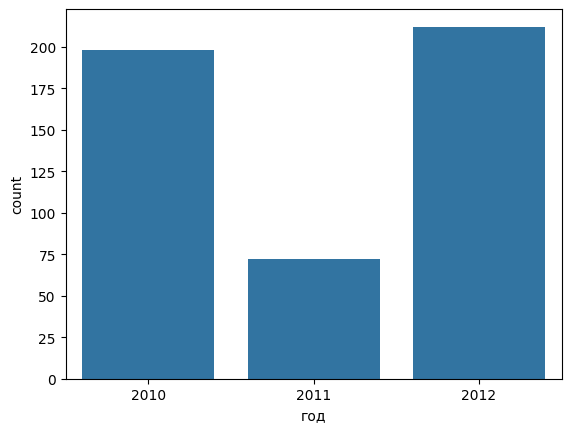

In [85]:
sns.countplot(df, x="год")
# Мало данных за 2011 год относительно 2010 и 2012

<Axes: xlabel='время_года', ylabel='Count'>

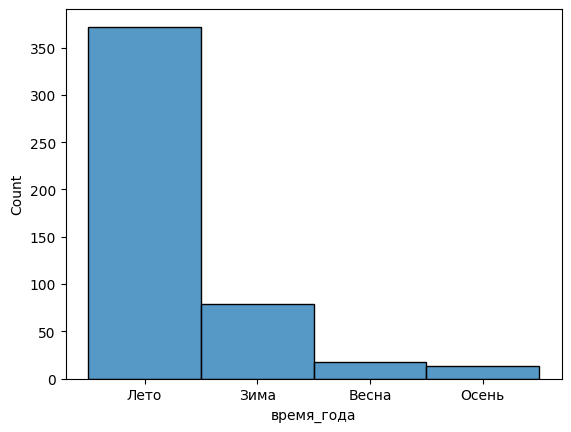

In [86]:
sns.histplot(df, x="время_года")
# Данные в основном брались за летний период

<Axes: xlabel='Count', ylabel='климат'>

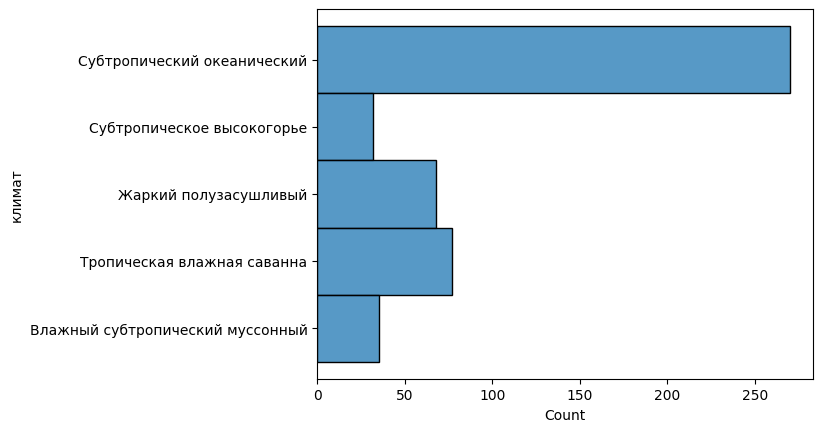

In [87]:
sns.histplot(df, y="климат")
# Логично что будет в большинстве субтропический океанический климат, т.к. страны, которые находятся в нашем датасете,
# как раз пролегают в нем

<Axes: xlabel='Count', ylabel='город'>

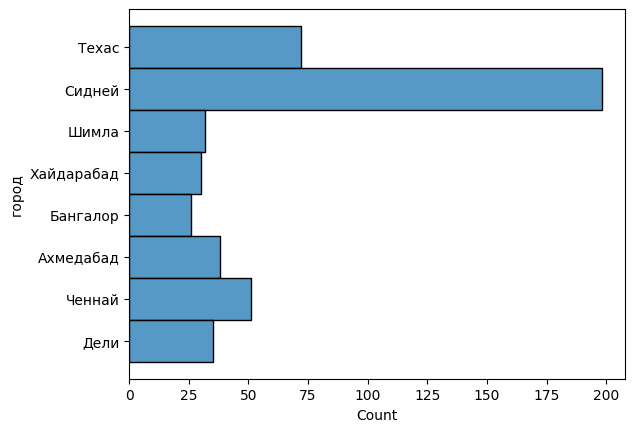

In [88]:
sns.histplot(df, y="город")
# Больше всего данных получено из Сиднея, Австралия и Индии

<Axes: xlabel='страна', ylabel='Count'>

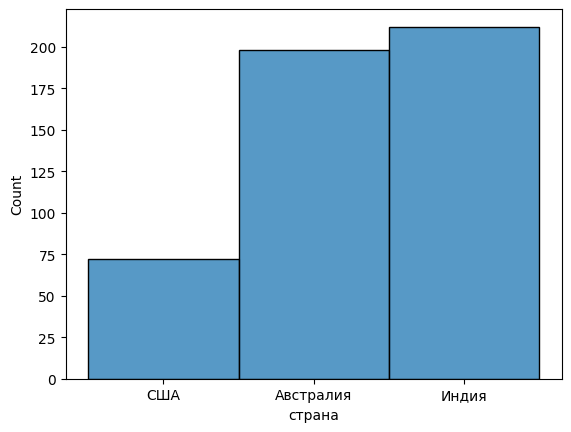

In [89]:
sns.histplot(df, x="страна")

<Axes: xlabel='способ_охлаждения', ylabel='Count'>

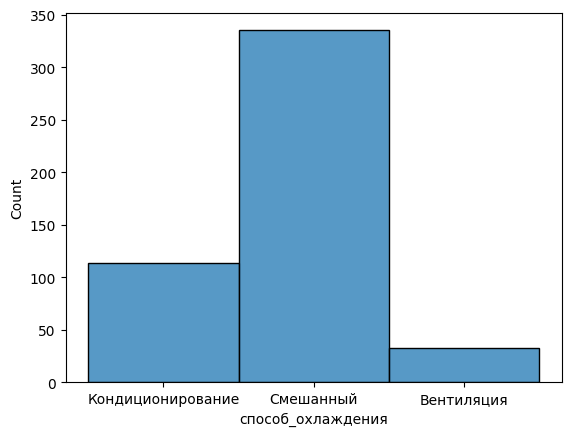

In [90]:
sns.histplot(df, x="способ_охлаждения")

<Axes: xlabel='ощущение_температуры'>

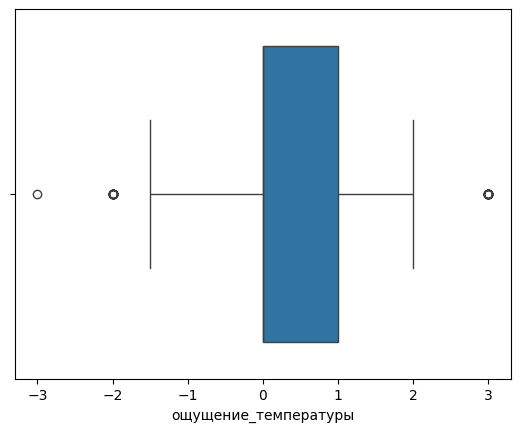

In [91]:
sns.boxplot(df, x="ощущение_температуры")
# Видны выбросы из графика, но их не следует удалять, т.к. они говорят о том, что некоторым клиентам было слишком холодно или слишком жарко, что влияет на оценку комфорта
# и непосредственно на выручку компании

<Axes: xlabel='ощущение_температуры_(bool)', ylabel='count'>

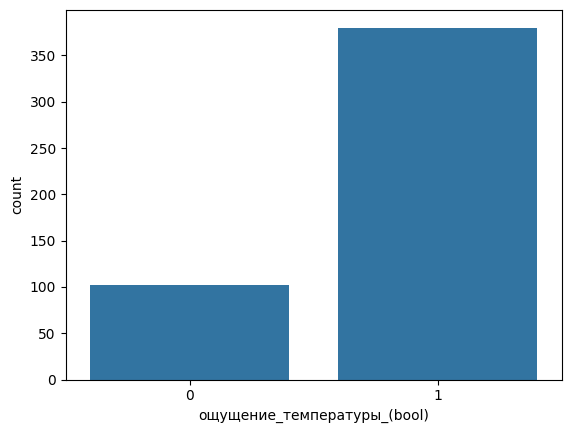

In [92]:
sns.countplot(df, x="ощущение_температуры_(bool)")
# Около 100 человек отметили что ощущаемая температура неприемлима, стоит взять эту группу для анализа, т.к. она составялет большую долю от всего числа клиентов данной выборки

<Axes: xlabel='предпочтительное_изменение_температуры', ylabel='Count'>

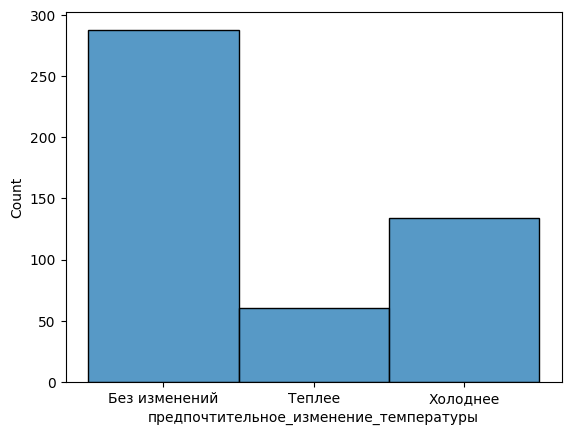

In [93]:
sns.histplot(df, x="предпочтительное_изменение_температуры")
# Также около 200 людей хотят изменить температуру, возможно их не устравивает способ охлаждения или способ обогрева

<Axes: xlabel='предпочтительное_изменение_движения_воздуха', ylabel='Count'>

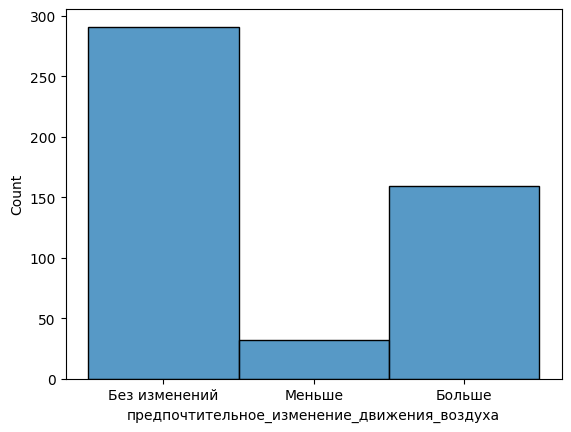

In [94]:
sns.histplot(df, x="предпочтительное_изменение_движения_воздуха")
# Большинство устраивает движение воздуха в помещении, но есть часть, которым нужна, скорее всего скорость больше, т.к. вероятно, им жарко

<Axes: xlabel='утепление'>

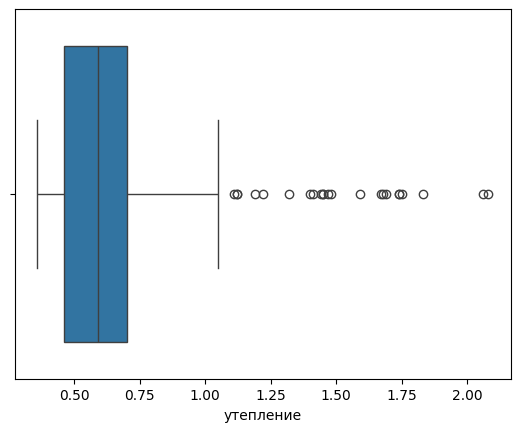

In [95]:
sns.boxplot(df, x="утепление")
# Достаточно много выбросов, но они не аномальные, т.к. в основном данные измерялись летом, об этом нам говорит график распределения времен года
# Соответсвенно утепление в это время ниже и значений большинство, а вот зимой наоборот, холоднее, соответственно утепленее выше, но т.к. данных по зиме мало, то
# появляются такие выбросы

<Axes: xlabel='rh', ylabel='Count'>

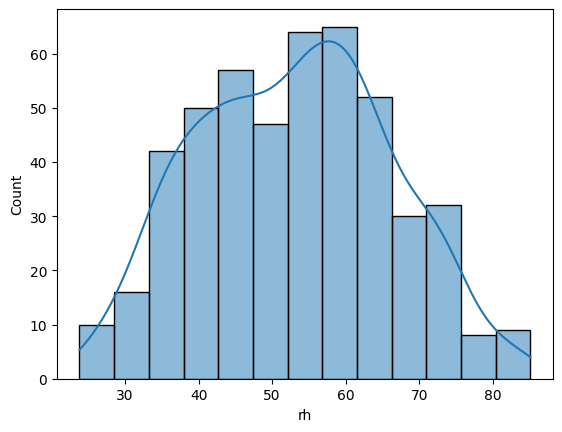

In [96]:
sns.histplot(df, x="rh", kde=True)
# Нормальная влажность в помещении 40-60 %, большиство значений из нашей выборки как раз лежат в этом диапозоне, но
# также есть немалое кол-во данных с повышенной/пониженной влажностью

<Axes: xlabel='скорость_воздуха'>

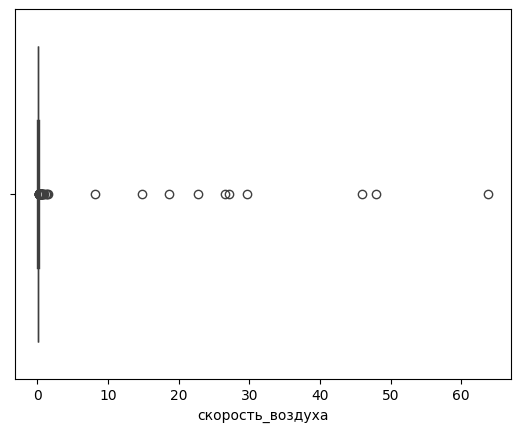

In [97]:
sns.boxplot(df, x="скорость_воздуха")
# А вот скорость воздуха у нас представлена в помещении, а не на улице, т.к. большинство значений находтся в диапозоне от 0 до 1 м/c что соотвествует норме(взято из интернета)
# Значения выше этого диапозона стоит рассматривать как выбросы

In [98]:
df[df["скорость_воздуха"] > 1]["скорость_воздуха"]
# Не хочется удалять 13 строчек, т.к. у нас 30 столбцов и мы можем потерять важную информацию
# Сначала рассчитаем верхнюю и нижнюю границу инерквартильного размаха

,скорость_воздуха
3,27.16
4,63.83
10,18.65
26,46.00
28,47.97
31,29.61
53,26.49
59,22.68
65,14.85
70,8.20


In [99]:
Q1 = df["скорость_воздуха"].quantile(0.25)
Q3 = df["скорость_воздуха"].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
print(Q3 + 3 * IQR, Q1 - 3 * IQR)

0.07 0.14 0.07
0.35000000000000003 -0.14


In [100]:
# Также рассчитаем медиану, среднее, моду
print(df["скорость_воздуха"].mean(), df["скорость_воздуха"].median(), df["скорость_воздуха"].mode().values[0])
# Медиана и мода соответствуют норме воздуха в помещении, ими и заменим выбросы

0.7636307053941909 0.1 0.08


In [101]:
speed_med = df["скорость_воздуха"].median()

df["скорость_воздуха"] = df["скорость_воздуха"].apply(lambda x: speed_med if x > Q3 + 3 * IQR else x)
df["скорость_воздуха"] = df["скорость_воздуха"].apply(lambda x: speed_med if x < Q1 - 3 * IQR else x)

<Axes: ylabel='скорость_воздуха'>

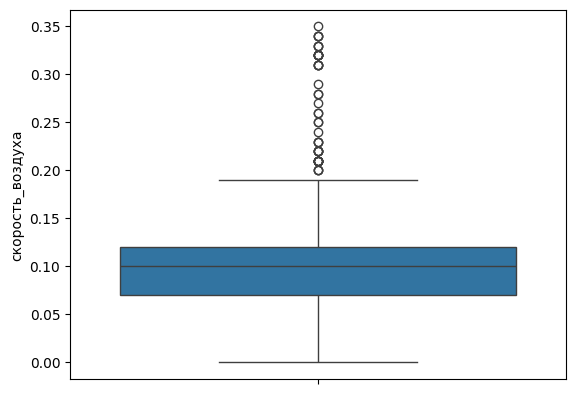

In [102]:
sns.boxplot(df, y="скорость_воздуха")

<Axes: xlabel='количество_рекламаций', ylabel='count'>

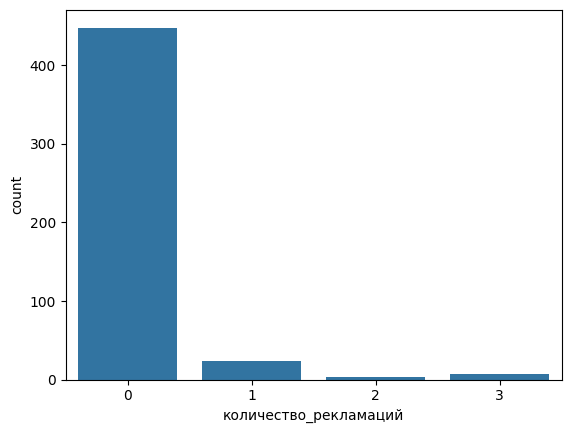

In [103]:
sns.countplot(df, x="количество_рекламаций")
# В основом жалоб нет, но люди кто жаловался на оборудование(а есть даже те, кто целых !3 раза жаловались) поставили скорее всего оценки ниже, давайте в этом убедимся

<Axes: xlabel='оценка_комфорта'>

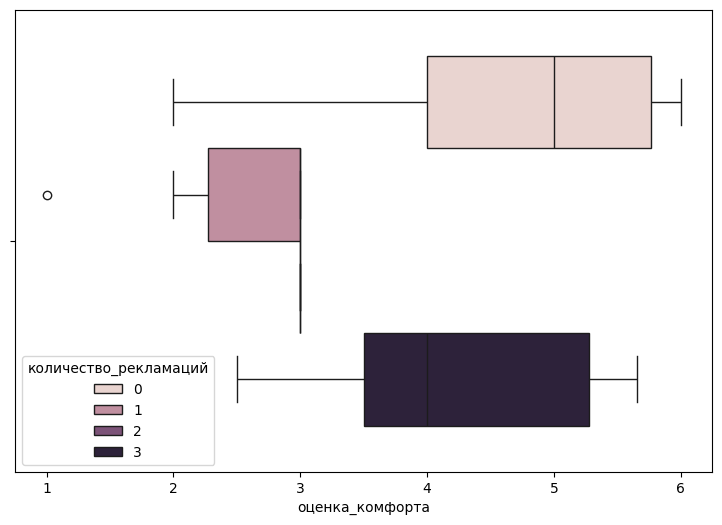

In [104]:
plt.figure(figsize=(9, 6))
sns.boxplot(df, x="оценка_комфорта", hue="количество_рекламаций")
# Действительно, медиана оценки комфорта больше у клиентов, которые не жаловались на оборудование, нежели те, кто жаловался

В итоге исследования и анализа, мы подчеркнули основную информацию для последующего анализа

# 3. Проведение расчётов и исследований



Задания:

  [1.   Создать дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту отдельно: мало (≤1), средне (=2), много (>2)](#first-task)

  [2.  Рассчитать средний возраст респондентов по полу и стране](#second-task)

  [3.   Добавить категориальный столбец, разделив респондентов на три категории по возрасту: до 44 лет - молодой возраст, 45 - 59 лет - средний возраст, 60 лет и больше - пожилой возраст.](#third-task)

  [4.   Рассчитать среднюю комфортную температуру в зависимости от возрастной категории](#fourth-task)

  [5.   Рассчитать медианное значение температуры и влажности для каждого типа охлаждения](#fifth-task)

  [6.   Добавить столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола](#sixth-task)

  [7.   Составить сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп](#seventh-task)

  [8.   Самостоятельно найти информацию по стандартной комфортной относительной влажности в помещениях (в нашем случае - офисы). Создать новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. Категории назначить самостоятельно](#eighth-task)

  [9.   Исследовать корреляцию между параметрами. Объяснить наиболее коррелирующие параметры, имеет ли это реальный смысл или просто особенность данных?](#nineth-task)

<a name="first-task"></a>
## 3.1


In [105]:
df['количество_рекламаций_кат'] = df['количество_рекламаций'].apply(
    lambda x: 'мало' if x <= 1 else ('средне' if x == 2 else 'много')
)
df['количество_рекламаций_кат'].head()

,количество_рекламаций_кат
0,мало
1,мало
2,мало
3,мало
4,мало


Был добавлен столбец, показывающий соотношение количества рекламаций

<a name="second-task"></a>
## 3.2

In [106]:
average_age = df.groupby(['пол', 'страна'])['возраст'].mean().round(1)
average_age

пол      страна   
Женский  Австралия    46.3
         Индия        38.4
Мужской  Австралия    42.6
         Индия        39.5
         США          36.2
Name: возраст, dtype: float64

Была создана сводная таблица по имеющимся данным, показывающая информацию о возрасте респондентов и их стран.

<a name="third-task"></a>
## 3.3

In [107]:
df['возраст_кат'] = df['возраст'].apply(
    lambda x: 'молодой возраст' if x <= 44 else ('средний возраст' if 45 <= x <= 59 else 'пожилой возраст')
)
df['возраст_кат'].head()

,возраст_кат
0,молодой возраст
1,молодой возраст
2,молодой возраст
3,молодой возраст
4,средний возраст


Был создан категориальный столбец, показывающий возраст респондентов.

<a name="fourth-task"></a>
## 3.4

In [108]:
df['комфортная_температура'] = np.where(
    (df['ощущение_температуры_(bool)'] == 1) & (df['предпочтительное_изменение_температуры'] == 'Без изменений'),
    df['температура_воздуха_в_помещении'],
    np.nan
)


average_temp_by_age_category = df.groupby('возраст_кат')['комфортная_температура'].mean().round(1).reset_index()
average_temp_by_age_category

,возраст_кат,комфортная_температура
0,молодой возраст,24.7
1,пожилой возраст,25.4
2,средний возраст,24.1


Была сделана сводная таблица, показывающая комфортную температуру, для разных возрастов

<a name="fifth-task"></a>
## 3.5


In [109]:
df['тип_охлаждения'] = np.where(df['способ_охлаждения'] == 'Смешанный',
                                 np.where(df['режим_при_смешанном_типе_охлаждения'] == 'Кондиционирование',
                                          'Кондиционирование(смешанный)',
                                          'Вентиляция(смешанный)'),
                                 df['способ_охлаждения'])
median_values = df.groupby('тип_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median().reset_index()
median_values

,тип_охлаждения,температура_воздуха_в_помещении,rh
0,Вентиляция,25.30,46.30
1,Вентиляция(смешанный),23.95,53.85
2,Кондиционирование,24.30,42.45
3,Кондиционирование(смешанный),24.80,57.60


Была сделана сводная таблица, показывающяя тип охлаждения, температуру в помещении и относительную влажность

<a name="sixth-task"></a>
## 3.6

In [110]:
df["удовлетворённость"] = np.where(
    (df["ощущение_температуры_(bool)"] == 1),
    1,
    0
)



group = df.groupby(["страна", "пол"]).agg(
    удовлетворённые=("удовлетворённость", "sum"),
    всего=("удовлетворённость", "count")
).reset_index()
group["процент_удовлетворённых"] = ((group["удовлетворённые"] / group["всего"]) * 100).round(1)
df = df.drop(columns=["процент_удовлетворённых"], errors="ignore")
df = df.merge(group[["страна", "пол", "процент_удовлетворённых"]], on=["страна", "пол"])
group

,страна,пол,удовлетворённые,всего,процент_удовлетворённых
0,Австралия,Женский,61,89,68.5
1,Австралия,Мужской,96,109,88.1
2,Индия,Женский,53,67,79.1
3,Индия,Мужской,116,145,80.0
4,США,Мужской,54,72,75.0


была сделана таблица, показывающяя удолетворенность респодентов

<a name="seventh-task"></a>
## 3.7

In [111]:
group_table_by_csattr = df.groupby(['страна', 'пол', 'возраст_кат']).agg({
    'температура_воздуха_в_помещении': 'mean',
    'температура_воздуха_на_улице': 'mean',
    'rh': 'mean'
}).round(1)

group_table_by_csattr

температура_воздуха_в_помещении  \
страна    пол     возраст_кат                                        
Австралия Женский молодой возраст                             23.8   
                  пожилой возраст                             24.9   
                  средний возраст                             24.1   
          Мужской молодой возраст                             24.1   
                  пожилой возраст                             24.7   
                  средний возраст                             24.0   
Индия     Женский молодой возраст                             26.7   
                  средний возраст                             24.2   
          Мужской молодой возраст                             26.0   
                  пожилой возраст                             29.3   
                  средний возраст                             26.2   
США       Мужской молодой возраст                             24.3   
                  средний возраст                             24.4   

                                   температура_воздуха_на_улице    rh  
страна    пол     возраст_кат                                          
Австралия Женский молодой возраст                          21.9  61.4  
                  пожилой возраст                          22.4  44.6  
                  средний возраст                          21.9  61.3  
          Мужской молодой возраст                          21.9  61.7  
                  пожилой возраст                          21.8  64.4  
                  средний возраст                          21.9  61.7  
Индия     Женский молодой возраст                          23.3  49.9  
                  средний возраст                          22.2  49.9  
          Мужской молодой возраст                          23.2  49.5  
                  пожилой возраст                          22.6  78.8  
                  средний возраст                          22.3  52.8  
США       Мужской молодой возраст                          24.1  39.0  
                  средний возраст                          24.1  38.8

Была сделана таблица, показывающяя среднюю температуру и влажность. Таблица сгрупированна по полу и стране.

<a name="eighth-task"></a>
## 3.8

* *Исследования, проведённые Всемирной организацией здравоохранения (ВОЗ), показывают, что поддержание оптимального микроклимата в помещениях играет важную роль в поддержании здоровья человека.*

* **Согласно рекомендациям ВОЗ, уровень влажности в помещениях должен составлять от 40% до 60%.** Это связано с тем, что как слишком низкая, так и слишком высокая влажность могут негативно влиять на здоровье, вызывая респираторные заболевания и ухудшая качество жизни.*

* *При влажности ниже 40% у человека может появиться сухость в дыхательных путях. А при более высокой влажности могут активно размножаться микробы и аллергены.*

In [112]:
df['относительная_влажность_кат'] = df['rh'].apply(
    lambda x: 'нормальная_влажность' if 40 <= x <= 60 else ('пониженная_влажность' if x < 40 else 'повышенная_влажность')
)

<Axes: xlabel='Count', ylabel='относительная_влажность_кат'>

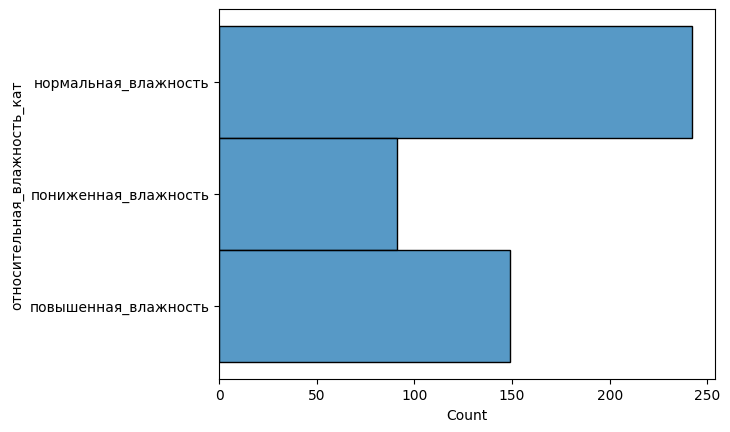

In [113]:
sns.histplot(df, y="относительная_влажность_кат")

Был добавлен столбец относительной влажности, основанный на рекомендациях ВОЗ.

<a name="nineth-task"></a>
## 3.9

Для исследование корреляции необходимо учитывать, что в таблице присутсствуют данные разных типов
1. Количественная - количественная - корреляция Пирсона/Спирмена
2. Категориальная - категориальная - хи-квадрат
3. Категориальная - количественная - корреляция Eta

При исследовании данных, можно заметить, что данные распределенные не нормально

вот один из графиков

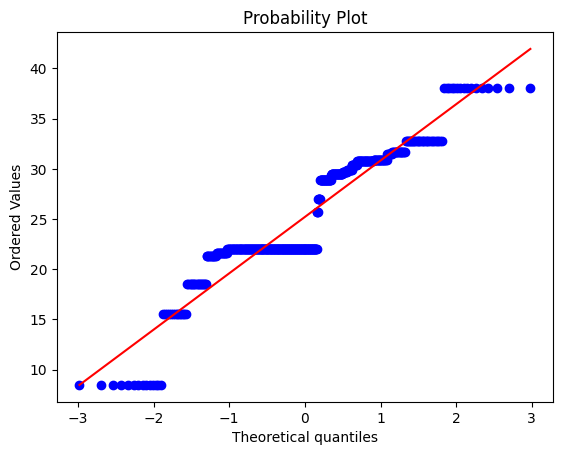

In [114]:
import scipy.stats as stats
stats.probplot(df['среднемесячная_температура_на_улице'], dist="norm", plot=plt)
plt.show()

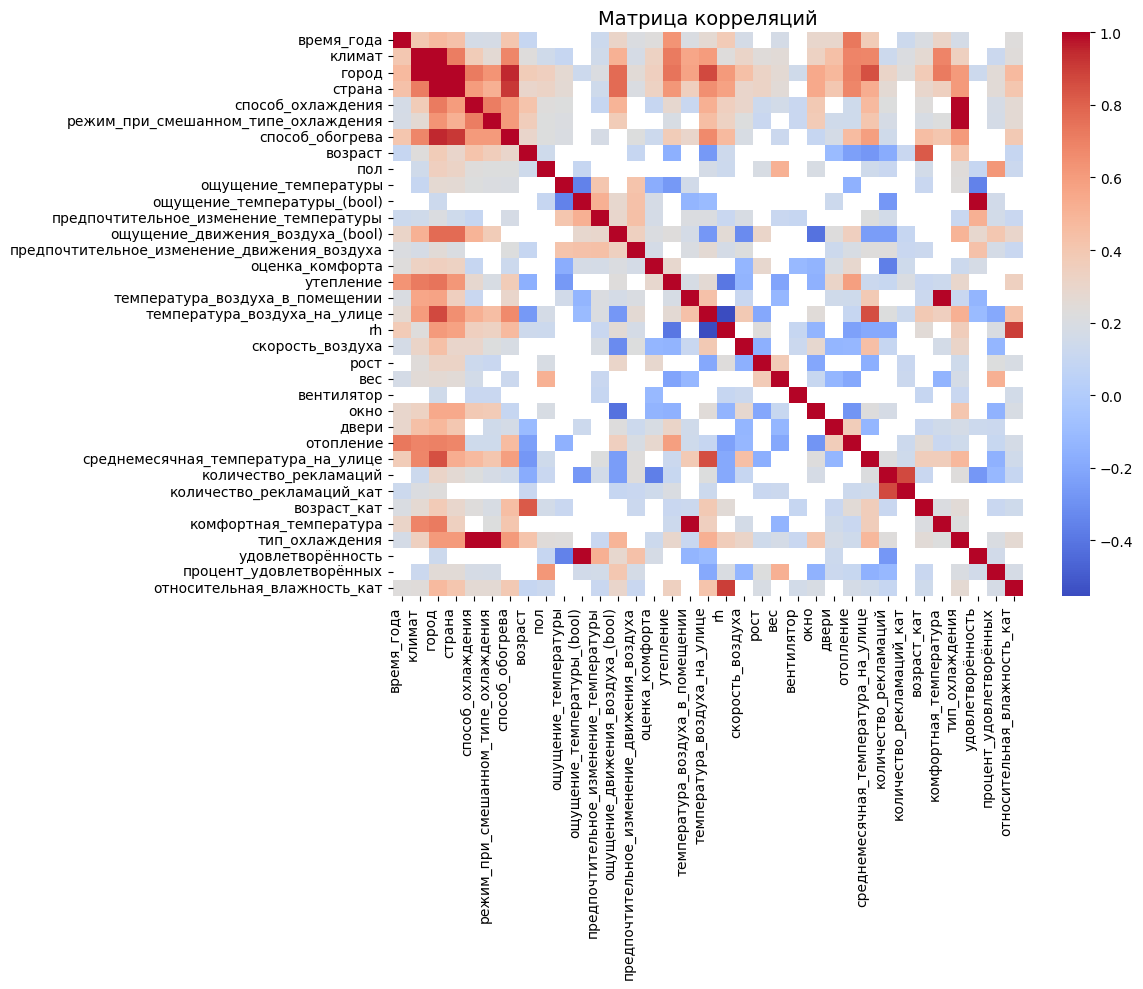

In [115]:
from scipy.stats import chi2_contingency, spearmanr, ttest_ind, pearsonr


def analyze_correlation(data):
    """
    Функция для анализа корреляции между столбцами таблицы и визуализации результатов.
    """
    def eta_squared(categories, numeric):
        """
        Рассчитывает коэффициент Eta для связи категориальных и числовых данных.
        """
        intra_group_variance = 0  # внутригрупповая дисперсия
        inter_group_variance = 0  # межгрупповая дисперсия (дисперсия средних значений категорий)

        # проверка на наличие дисперсии в числовых данных
        if np.var(numeric) == 0:
            return 0

        # вычисление внутригрупповой и межгрупповой дисперсии
        for cat in categories.unique():
            group_values = numeric[categories == cat]  # числовые данные для текущей категории
            intra_group_variance += np.sum((group_values - np.mean(group_values)) ** 2)  # сумма отклонений внутри группы
            inter_group_variance += len(group_values) * (np.mean(group_values) - np.mean(numeric)) ** 2  # межгрупповая дисперсия

        total_variance = intra_group_variance + inter_group_variance  # Общая дисперсия
        return round((inter_group_variance / total_variance) ** 0.5, 2) if total_variance != 0 else np.nan

    def cramers_v_and_p(data, col1, col2):
        """
        Вычисляет коэффициент Крамера V и p-значение для двух категориальных столбцов.
        """
        contingency = pd.crosstab(data[col1], data[col2])  # таблица сопряженности
        if contingency.isnull().values.any():
            return np.nan, np.nan

        chi2, p, _, _ = chi2_contingency(contingency)
        n = contingency.values.sum()  # общее число наблюдений
        r_min = min(contingency.shape) - 1
        v = np.sqrt((chi2 / n) / r_min)
        return round(v, 2), round(p, 4)

    def build_correlation_matrix(data):
        """
        Создает матрицу корреляции с учетом типов данных в столбцах.
        """
        corr_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
        for col1 in data.columns:
            for col2 in data.columns:
                if col1 == col2:
                    corr_matrix.loc[col1, col2] = 1.0
                elif data[col1].dtype in ('object', 'category') and data[col2].dtype in ('object', 'category'):
                    corr_matrix.loc[col1, col2] = cramers_v_and_p(data, col1, col2)[0]
                elif data[col1].dtype in ('int64', 'float64') and data[col2].dtype in ('int64', 'float64'):
                    spearman_corr = data[[col1, col2]].corr(method='spearman').iloc[0, 1]
                    corr_matrix.loc[col1, col2] = spearman_corr
                else:
                    if data[col1].dtype in ('object', 'category'):
                        corr_matrix.loc[col1, col2] = eta_squared(data[col1], data[col2])
                    elif data[col2].dtype in ('object', 'category'):
                        corr_matrix.loc[col1, col2] = eta_squared(data[col2], data[col1])

        return corr_matrix.astype('float64')

    # удаляем столбец 'год', мешает
    data = data.drop(columns=['год'])

    # создание матрицы корреляции
    correlation_matrix = build_correlation_matrix(data)

    # фильтрируем
    filtered_corr = correlation_matrix[correlation_matrix.abs() >= 0.1]

    # построение тепловой карты корреляций
    plt.figure(figsize=(12, 10))
    sns.heatmap(filtered_corr, cmap='coolwarm', fmt='.1f')
    plt.xticks(rotation=90, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Матрица корреляций', fontsize=14)
    plt.tight_layout()
    plt.show()

analyze_correlation(df)

По матрице корреляций видно, что оценка комфорта зависит от климата, города, страны, ощущения температуры, кол-ва жалоб и скорости воздуха в помещении.

Также заметна логическая корреляция между старной и климатом, городом и климатом, страной и городом. Также из-за предобработки данных и добавления новых признаков появилась сильная корреляция между типом охлаждения и способом охлаждения, т.к. для создания тип была использована колонка способ.

Ну а действительно ли влияют на оценку комфорта вышеупомянутые признаки или это случайность, нужно выяснить при помощи проверки гипотез.

## Вывод
В ходе проведения расчетов и исследования, мы выразили главные факотры, влиящие на комфорт респодентов


# 3. Проверка гипотез

Обусловимся, что для проверки данных на нормальность и проверки гипотез возьмем уровень принятия решений = 0.05

## Влияет ли способ охлаждения на оценку комфорта?

H0: распределения всех выборок одинаковы

H1: распределения одной или нескольких выборок не равны

In [116]:
from scipy.stats import f_oneway, shapiro, kruskal, ttest_ind, mannwhitneyu

g1 = df[df["способ_охлаждения"] == "Кондиционирование"]["оценка_комфорта"]
g2 = df[df["способ_охлаждения"] == "Вентиляция"]["оценка_комфорта"]
g3 = df[df["способ_охлаждения"] == "Смешанный"]["оценка_комфорта"]

In [117]:
if shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05 and shapiro(g3)[1] >= 0.05:
    print(f_oneway(g1, g2, g3))
else:
    print(kruskal(g1, g2, g3))

KruskalResult(statistic=8.691684289253956, pvalue=0.01296058896024824)


На уровне значимости 0.05 отвергаем нулевую гипотезу в пользу альтернативной. Различия между этими группами получены не случайно

<Axes: xlabel='способ_охлаждения', ylabel='оценка_комфорта'>

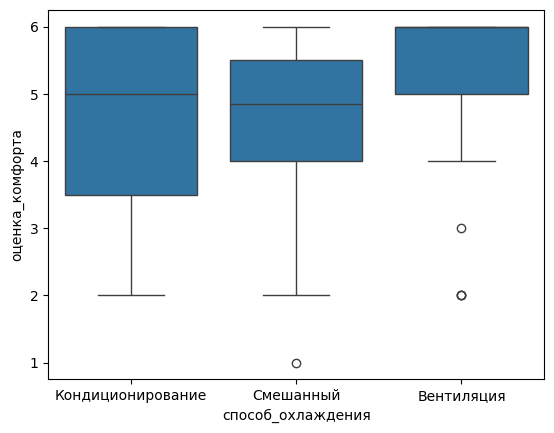

In [118]:
sns.boxplot(df, x="способ_охлаждения", y="оценка_комфорта")

Вывод: клиенты с механическими системами вентиляции и естественным охлаждением, довольны чаще и оценивают комфорт выше чем люди с механическим типом охлаждения. Из этого следует что нужно большуя часть денег инвестировать в вентиляционный тип климатического оборудования, чтобы повысить выручку. Также нужно выявить причины более низких оценок клиентов с другими способами охлаждения

## Влияет ли пол на оценку комфорта?

H0: Пол не влияет на оценку комфорта

H1: Пол влияет на оценку комфорта

In [119]:
# Разделение групп
male_comfort = df[df['пол'] == 'Мужской']['оценка_комфорта']
female_comfort = df[df['пол'] == 'Женский']['оценка_комфорта']

# Проверка нормальности распределения
male_shapiro_p = shapiro(male_comfort)[1]
female_shapiro_p = shapiro(female_comfort)[1]

print(mannwhitneyu(male_comfort, female_comfort, alternative='two-sided'))

MannwhitneyuResult(statistic=25219.0, pvalue=0.8835214552412596)


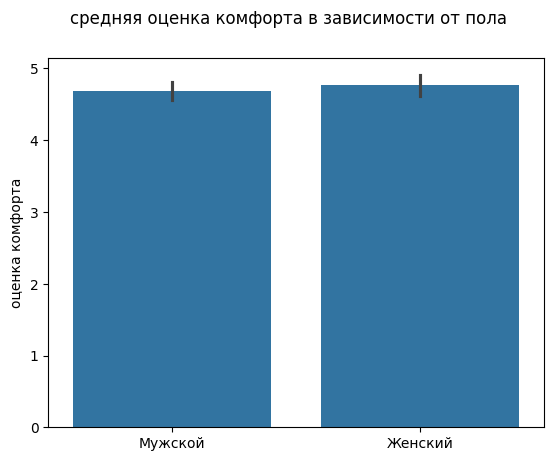

In [120]:
sns.barplot(data=df, x='пол', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта')
plt.suptitle('cредняя оценка комфорта в зависимости от пола')
plt.show()

<Axes: xlabel='пол', ylabel='оценка_комфорта'>

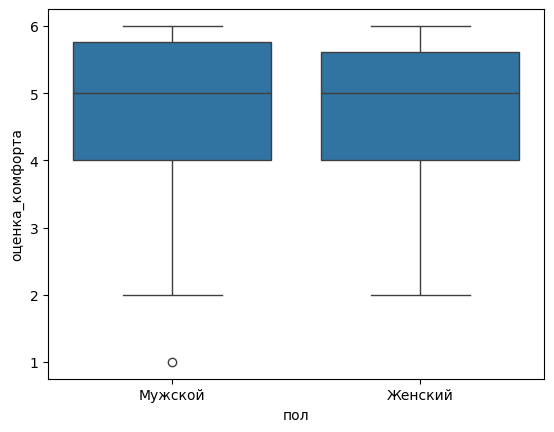

In [121]:
sns.boxplot(df, x="пол", y="оценка_комфорта")

На уровне значимости = 0.05, принимаем гипотезу H0

Вывод: пол не влияет на оценку комфорта

## Влияет ли возрастная группа на оценку комфорта?

H0: Возраст не влияет на оценку комфорта

H1: Возраст влияет на оценку комфорта

In [122]:
filtered_groups = df[['возраст_кат', 'оценка_комфорта']]
print(filtered_groups.groupby('возраст_кат')['оценка_комфорта'].count())

возраст_кат
молодой возраст    282
пожилой возраст     12
средний возраст    188
Name: оценка_комфорта, dtype: int64


In [123]:
# Разделение групп
young_comfort = filtered_groups[filtered_groups['возраст_кат'] == 'молодой возраст']['оценка_комфорта']
middle_comfort = filtered_groups[filtered_groups['возраст_кат'] == 'средний возраст']['оценка_комфорта']
elder_comfort = filtered_groups[filtered_groups['возраст_кат'] == 'пожилой возраст']['оценка_комфорта']

# Проверка нормальности распределения
young_shapiro_p = shapiro(young_comfort)[1]
middle_shapiro_p = shapiro(middle_comfort)[1]
elder_shapiro_p = shapiro(elder_comfort)[1]

print(young_shapiro_p, middle_shapiro_p, elder_shapiro_p)

9.066447581220848e-11 1.7327387062364036e-08 0.7244873710454721


Распределение ненормальное, применяем тест Краскала-Уоллиса

In [124]:
h_stat, pvalue = kruskal(young_comfort, middle_comfort, elder_comfort)
print(f"h_stat = {h_stat}")
print(f"p-value = {pvalue}")

h_stat = 0.10217251830797837
p-value = 0.9501967038334928


Принимаем нулевую гипотезу: возраст не влияет на оценку комфорта


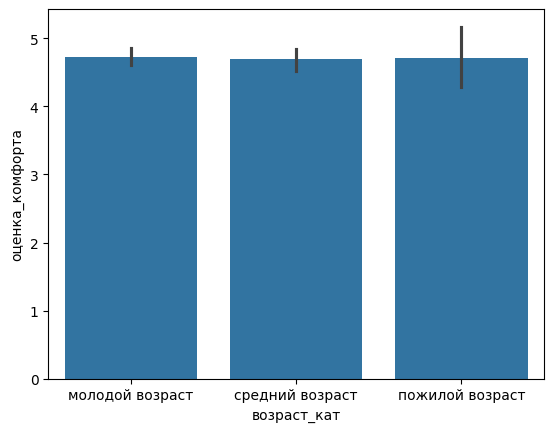

In [125]:
sns.barplot(data=df, x='возраст_кат', y='оценка_комфорта')
plt.show()

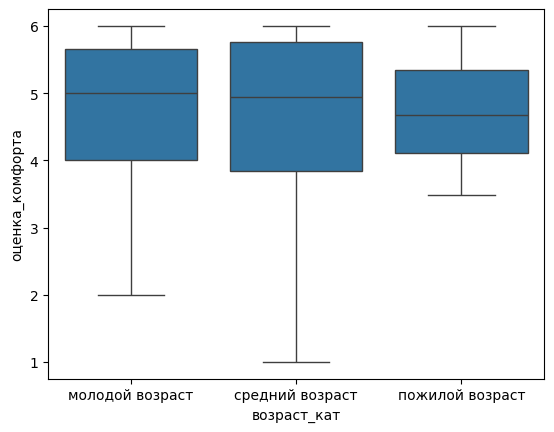

In [126]:
sns.boxplot(data=df, x='возраст_кат', y='оценка_комфорта')
plt.show()

## Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?

H0: оценка комфорта не зависит от количества рекламаций

H1: оценка комфорта зависит от количества рекламаций

разделеним данныe по категориям рекламаций

In [127]:
low_complaints = df[df['количество_рекламаций_кат'] == 'мало']['оценка_комфорта']
medium_complaints = df[df['количество_рекламаций_кат'] == 'средне']['оценка_комфорта']
high_complaints = df[df['количество_рекламаций_кат'] == 'много']['оценка_комфорта']

Проверим нормальность распределения для каждой группы

In [128]:
low_shapiro_p = shapiro(low_complaints)[1]
medium_shapiro_p = shapiro(medium_complaints)[1]
high_shapiro_p = shapiro(high_complaints)[1]
print(low_shapiro_p, medium_shapiro_p, high_shapiro_p)

2.722290542922157e-14 1.0 0.499863992743908


Распредление для малого количества жалоб - ненормальное
применяем тест Краскала-Уоллиса

In [129]:
h_stat, p_value = kruskal(low_complaints, medium_complaints, high_complaints)
print(f'h-stat: {round(h_stat, 3)}')
print(f'p-value: {round(p_value, 3)}')

h-stat: 8.434
p-value: 0.015


p-value сильно маленькое - различия между группами значимыми



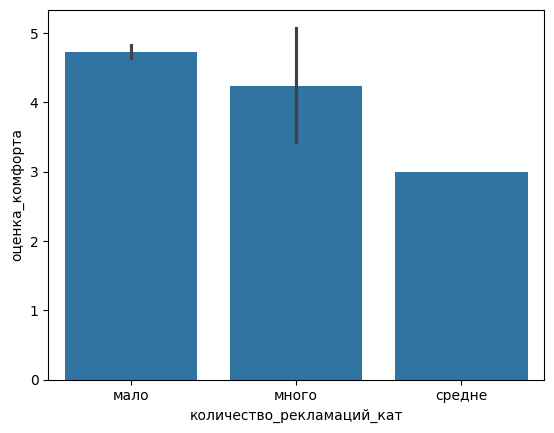

In [130]:
sns.barplot(data=df, x='количество_рекламаций_кат', y='оценка_комфорта')
plt.show()

Принимаем гиппотезу H1:
Причем чем меньше рекламаций, тем выше оценка комфорта и наоборот


Вывод: комфорт зависит от рекламаций.

## Проверить гипотезу о том, что оценка комфорта отличается в зависимости от страны

H0: разницы в оценке комфорта между странами нет

H1: разницы в оценке комфорта между странами есть

In [131]:
countries = df['страна'].unique()
countries_count = df.groupby(df['страна'])['оценка_комфорта'].count()
print(countries, countries_count)

['США' 'Австралия' 'Индия'] страна
Австралия    198
Индия        212
США           72
Name: оценка_комфорта, dtype: int64


In [132]:
countries = df['страна'].unique()
# Разделяем оценки комфорта по каждой стране
country_comforts = [df[df['страна'] == country]['оценка_комфорта'] for country in countries]
# Проверка нормальности для каждой страны
normality_results = [shapiro(country_comfort)[1] for country_comfort in country_comforts]
print(normality_results)

[0.0010709980608641344, 5.97515511381313e-06, 3.495044973510117e-15]


 используем тест Краскала-Уоллиса

In [133]:
h_stat, p_value = kruskal(*country_comforts)
print(f"h-stat: {h_stat}")
print(f'p-value: {p_value}')

h-stat: 64.75749277068398
p-value: 8.67139787946923e-15


p-value теста Краскала-Уоллиса меньше 0.05, это означает, что есть статистически значимая разница в средней оценке комфорта между странами.


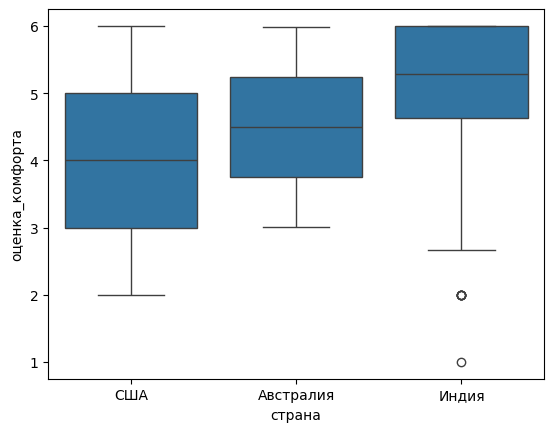

In [134]:
sns.boxplot(data=df, x='страна', y='оценка_комфорта')
plt.show()

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Вывод: оценка комфорта зависит от страны

## Проверить гипотезу о том, что оценка комфорта зависит от климата

H0: разницы в оценке комфорта не зависит от климата

H1: разницы в оценке комфорта зависит от климата

In [135]:
climates = df['климат'].unique()

# Разделяем оценки комфорта по каждому климату
climate_comforts = [df[df['климат'] == climate]['оценка_комфорта'] for climate in climates]

# Проверка нормальности для каждой группы по климату
normality_results = [shapiro(climate_comfort)[1] for climate_comfort in climate_comforts]
print(normality_results)

[2.9642218559918758e-05, 1.008727626592855e-06, 1.4068895197348771e-06, 1.0754510161869147e-07, 1.2410235628726127e-05]


используем тест Краскала-Уоллиса

In [136]:
h_stat, p_value = kruskal(*climate_comforts)
print(f'p-value: {p_value}')
print(f'h_stat: {h_stat}')

p-value: 2.9907872321669937e-14
h_stat: 69.43252145698786


p-value теста Краскала-Уоллиса меньше 0.05, это означает, что есть статистически значимая разница в средней оценке комфорта между разными климтическими зонами.

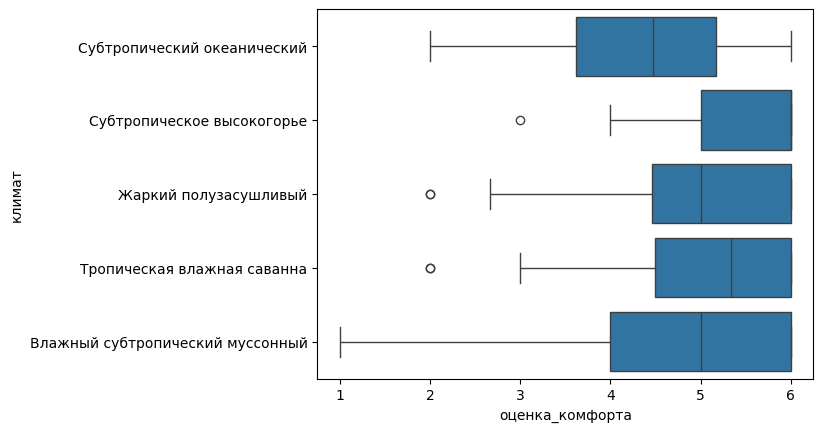

In [137]:
sns.boxplot(data=df, x='оценка_комфорта', y='климат')

plt.show()

Отвергаем гиппотезу H0 в пользу H1

## Проверить гипотезу о том, что оценка комфорта отличается в зависимости от влажности


H0: разница в оценке комфорта не зависит от влажности

H1: разница в оценке комфорта зависит от влажности

In [138]:
humidity_categories = df['относительная_влажность_кат'].unique()
# Разделяем оценки комфорта по каждой категории влажности
humidity_comforts = [df[df['относительная_влажность_кат'] == category]['оценка_комфорта'] for category in humidity_categories]
# Проверка нормальности для каждой группы по влажности
normality_results = [shapiro(humidity_comfort)[1] for humidity_comfort in humidity_comforts]
print(normality_results)

[4.271739651108822e-09, 7.523465782785449e-08, 5.985094814181565e-06]


используем  тест Краскала-Уоллиса

In [139]:
h_stat, p_value = kruskal(*humidity_comforts)
print(f'p-value: {round(p_value, 2)}')
print(h_stat)

p-value: 0.16
3.6695255366502066


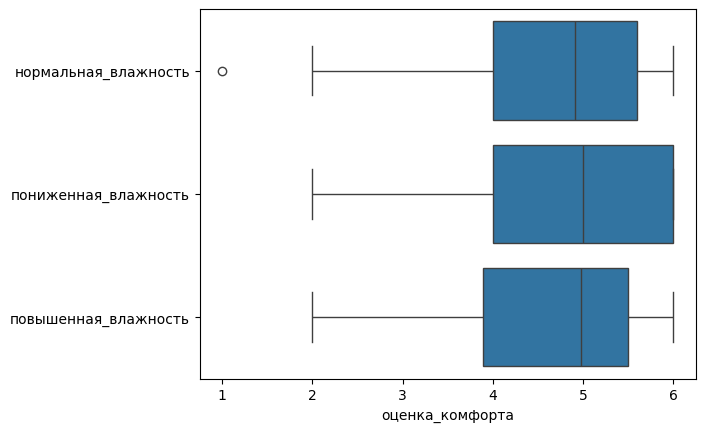

In [140]:
sns.boxplot(data=df, x='оценка_комфорта', y='относительная_влажность_кат')
plt.ylabel('')
plt.show()

Принимаем H0 - разница в оценке комфорта не зависит от влажности

## Проверить гипотезу о том, что предпочтительное изменение температуры отличается в зависимости от влажности

H0: между предпочтительной температурой и относительная влажность нет связи.

H1: между предпочтительной температурой и относительная влажность есть связь.

In [141]:
# Построение таблицы сопряженности
contingency_table = pd.crosstab(df['относительная_влажность_кат'], df['предпочтительное_изменение_температуры'])
# Хи-квадрат тест
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
# Результаты теста
print(f'Chi2 Statistic: {round(chi2_stat, 4)}')
print(f'p-value: {round(p_value, 4)}')

Chi2 Statistic: 11.7284
p-value: 0.0195


В данном случае p-value = 0.0195.


Это означает, что между Предпочтительной температурой и относительная влажность есть связь

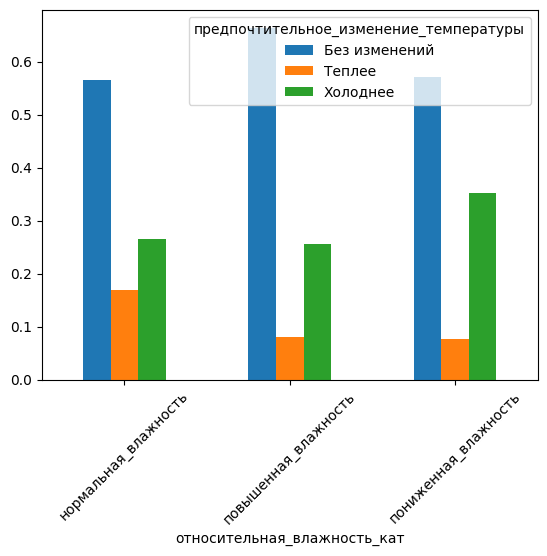

In [142]:
contingency_table_prop = contingency_table.div(contingency_table.sum(axis=1), axis=0)
# Построение составленной столбчатой диаграммы
contingency_table_prop.plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

принимаем H1

Вывод: относительная влажность влияет на предвочтение температурного режима

## Проверить гипотезу о том, что оценка комфорта отличается в зависимости от времени года

H0: разница в оценке комфорта не зависит от времени года

H1: разница в оценке комфорта зависит от времени года

In [143]:
seasons = df['время_года'].unique()
# Разделяем оценки комфорта по каждому времени года
season_comforts = [df[df['время_года'] == season]['оценка_комфорта'] for season in seasons]
# Проверка нормальности для каждой группы по времени года
normality_results = [shapiro(season_comfort)[1] for season_comfort in season_comforts]
print(normality_results)

[8.133345104606246e-11, 1.2039103121291151e-07, 0.4286920502881848, 0.0731204363201869]


Используем тест Краскала-Уоллиса

In [144]:
h_stat, p_value = kruskal(*season_comforts)
print(f'H-statistic: {h_stat}, p-value: {p_value:}')

H-statistic: 25.028389733082555, p-value: 1.5230891867231302e-05


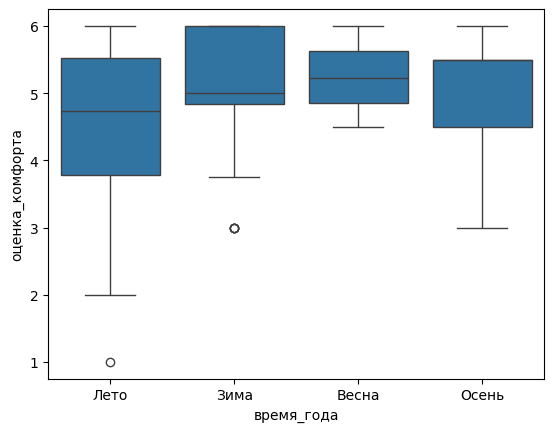

In [145]:
sns.boxplot(data=df, x='время_года', y='оценка_комфорта')
plt.show()

p-value меньше 0.05, это означает, что между временами года есть статистически значимые различия в средней оценке комфорта,
принимаем альтернативную гипотезу(H1)

Вывод: Время года влияет на оценку комфорта

## Проверить гипотезу о том, что оценка комфорта отличается в зависимости от времени года

## Вывод по гипотезам

В ходе проверки гипотез была выявлена значительные различия в оценке комфорта между странами, в Индии они выше, чем в США.

От количества рекламацию зависит комфорт клиентов.

Также значительное влияние оказывает и время года, весной и зимой оценки выше, опять же, это может значить что нужно подстраиваться именно под эти времена года.

Субтропическое высокогорье и тропическая влажная саванна - климаты, показывающие более высокие оценки, тоже стоит расширить влияние в странах с таким климатом


# Регрессионное моделирование

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          482 non-null    int64  
 1   время_года                                   482 non-null    object 
 2   климат                                       482 non-null    object 
 3   город                                        482 non-null    object 
 4   страна                                       482 non-null    object 
 5   способ_охлаждения                            482 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          482 non-null    object 
 7   способ_обогрева                              482 non-null    object 
 8   возраст                                      482 non-null    float64
 9   пол                                          482 non-null    object 
 10  ощ

In [147]:
# Разделяем признаки, которые будт использоваться в обучении
cat_features = ["тип_охлаждения", "режим_при_смешанном_типе_охлаждения", "способ_обогрева",
                "предпочтительное_изменение_движения_воздуха", "относительная_влажность_кат"]

count_features = ["ощущение_температуры", "ощущение_движения_воздуха_(bool)", "утепление",
                  "rh", "вентилятор", "отопление", "температура_воздуха_в_помещении"]
df_train = df[cat_features + count_features].reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 12 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   тип_охлаждения                               482 non-null    object 
 1   режим_при_смешанном_типе_охлаждения          482 non-null    object 
 2   способ_обогрева                              482 non-null    object 
 3   предпочтительное_изменение_движения_воздуха  482 non-null    object 
 4   относительная_влажность_кат                  482 non-null    object 
 5   ощущение_температуры                         482 non-null    float64
 6   ощущение_движения_воздуха_(bool)             482 non-null    int64  
 7   утепление                                    482 non-null    float64
 8   rh                                           482 non-null    float64
 9   вентилятор                                   482 non-null    int64  
 10  от

<Axes: xlabel='ощущение_температуры'>

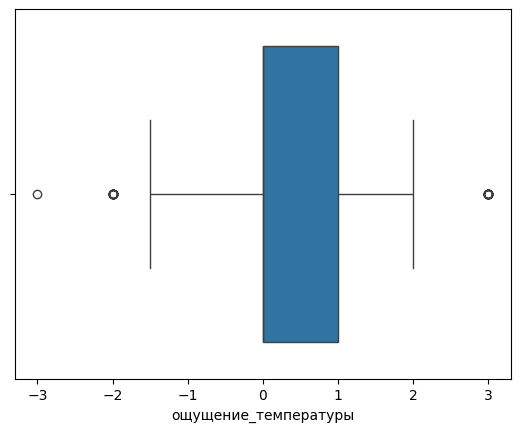

In [148]:
sns.boxplot(df_train, x="ощущение_температуры")

In [149]:
# По графику ощущения температуры видны выбросы, ранее мы их оставили, т.к. значения этих выбросов важны для бизнеса, т.к. учитывают мнение всех клиентов,
# Но линейной модели они могут навредить, поэтому удалим их
Q1 = df_train["ощущение_температуры"].quantile(0.25)
Q3 = df_train["ощущение_температуры"].quantile(0.75)
IQR = Q3 - Q1

df_train["ощущение_температуры"] = df_train["ощущение_температуры"].apply(lambda x: None if (x > Q3 + 1.5 * IQR or x < Q1 - 1.5 * IQR) else x)

<Axes: xlabel='ощущение_движения_воздуха_(bool)', ylabel='count'>

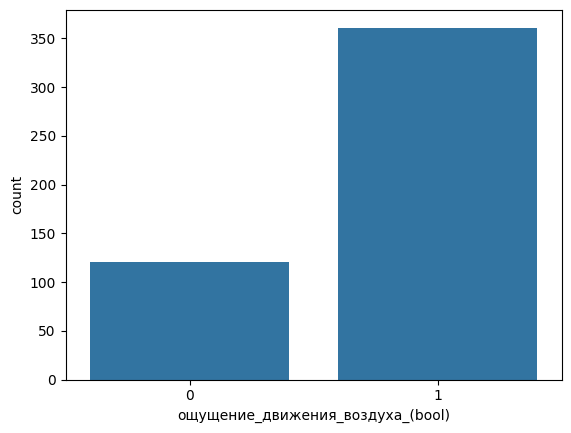

In [150]:
sns.countplot(df_train, x="ощущение_движения_воздуха_(bool)")

<Axes: xlabel='утепление'>

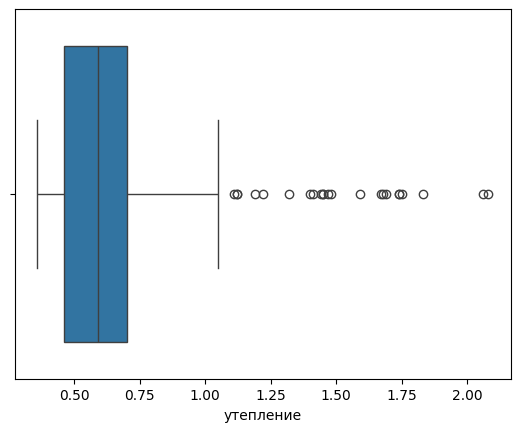

In [151]:
sns.boxplot(df_train, x="утепление")

In [152]:
# Также и с утеплением, дабы метрики модели не снизились из-за выбрасов, мы их удалим
Q1 = df_train["утепление"].quantile(0.25)
Q3 = df_train["утепление"].quantile(0.75)
IQR = Q3 - Q1

df_train["утепление"] = df_train["утепление"].apply(lambda x: None if (x > Q3 + 1.5 * IQR or x < Q1 - 1.5 * IQR) else x)

<Axes: xlabel='rh'>

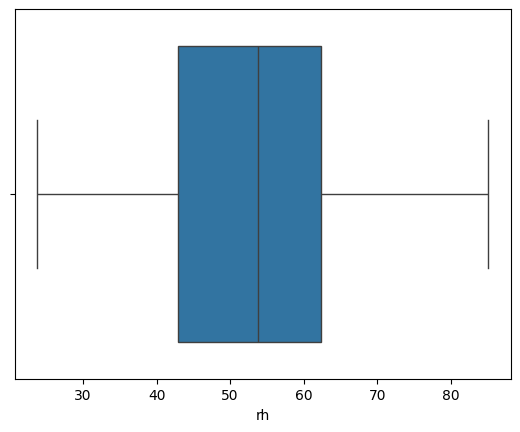

In [153]:
sns.boxplot(df_train, x="rh")

<Axes: xlabel='вентилятор', ylabel='count'>

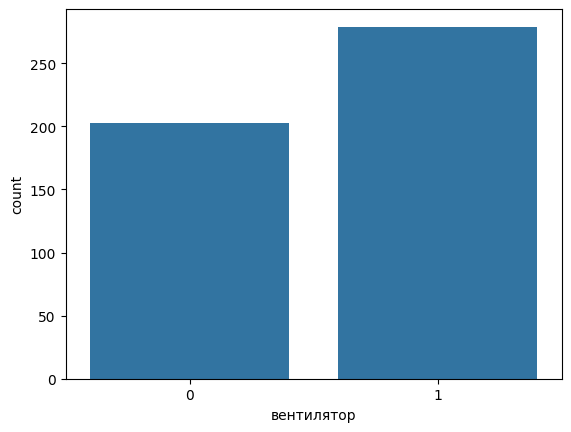

In [154]:
sns.countplot(df_train, x="вентилятор")

<Axes: xlabel='отопление', ylabel='count'>

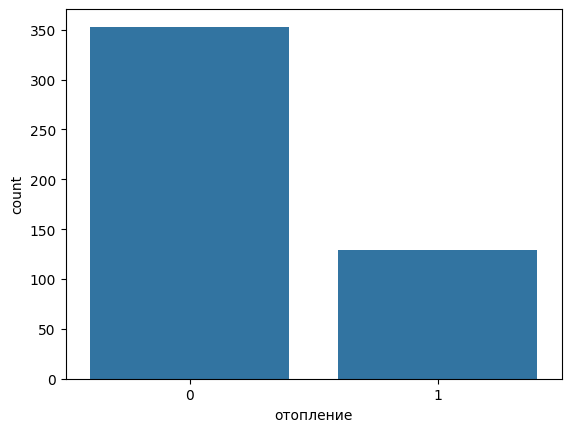

In [155]:
sns.countplot(df_train, x="отопление")

In [156]:
df_train = df_train.dropna().reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 12 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   тип_охлаждения                               413 non-null    object 
 1   режим_при_смешанном_типе_охлаждения          413 non-null    object 
 2   способ_обогрева                              413 non-null    object 
 3   предпочтительное_изменение_движения_воздуха  413 non-null    object 
 4   относительная_влажность_кат                  413 non-null    object 
 5   ощущение_температуры                         413 non-null    float64
 6   ощущение_движения_воздуха_(bool)             413 non-null    int64  
 7   утепление                                    413 non-null    float64
 8   rh                                           413 non-null    float64
 9   вентилятор                                   413 non-null    int64  
 10  от

In [157]:
ohe = OneHotEncoder(sparse_output=False)
cat_data = pd.DataFrame(ohe.fit_transform(df_train[cat_features]), columns=ohe.get_feature_names_out())

df_ohe = pd.concat([cat_data.reset_index(drop=True), df_train], axis=1)
df_ohe = df_ohe.drop(cat_features, axis=1)

In [158]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_ohe.drop(columns=["температура_воздуха_в_помещении"]),
                                                    df_ohe['температура_воздуха_в_помещении'], test_size=0.15, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

valid_test = lr.predict(x_test)
valid_train = lr.predict(x_train)

print(f"train mae: {round(mean_absolute_error(y_train, valid_train), 2)}")
print(f"test mae: {round(mean_absolute_error(y_test, valid_test), 2)}")
# Метрики показывают что мы близки к истинным значениям и модель не переобучилась
# Но в реальном бизнесе ее использовать не стоит, т.к. она обучалась на очень маленькой выборке, и это не дает нам представление о генеральной

train mae: 1.19
test mae: 1.47
